In [992]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from google.colab import drive

drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Osteoarthritis dataset/All Clinical/cleaned_data.csv')

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,No
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,Yes
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,Yes
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,Yes
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,No


# **Pre-processing**

In [993]:
## Replace 'No' and 'Yes' by 0 and 1 in the outcome column

df['cumulative_outcome'] = df['cumulative_outcome'].apply(lambda x: 1 if x == 'Yes' else 0)
df.head()

,ID,P01KPNREV,P01KPNLEV,P01KPACT30,P01HPNR12,P01HPNL12,V00SF2,V00SF3,V00SF8,V00WPRKN1,V00WPRKN2,V00P7RKFR,V00KSXRKN1,V00DIRKN1,V00DIRKN2,V00DIRKN14,V00WPLKN1,V00WPLKN2,V00P7LKFR,V00KSXLKN1,V00DILKN1,V00DILKN2,V00DILKN14,V00KOOSFX5,P02KPNRCV,P02KPNLCV,P01KPR30CV,P01KPL30CV,P01KPACTCV,P01HPR12CV,P01HPL12CV,P01KPA30CV,V00P7RKRCV,V00P7LKRCV,P01PMRKRCV,P01PMLKRCV,V00WOMTSL,V00WOMTSR,P01BL12SXL,P01BL12SXR,...,V00RUBCV,V00CAPSNCV,V00BRACCV,V00YOGACV,V00HERBCV,V00RELACV,V00SPIRCV,P01RASTASV,P02KSURGCV,V00OTHCAMC,V00OTHCAM,V00DISCOMF,V00LFXCOMP,V00LFXPN,V00EKRSL,V00REXPN,V00EKRSR,V00RFXCOMP,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,V00VITDCV,V00CALCMCV,V00VIT9,V00VIT1,P01BMI,V00PASE,P01FAMKR,P02WTGA,V00RKEFFB,V00RKEFFPT,V00LKEFFB,V00LKEFFPT,V00RKRFXPN,V00LKRFXPN,V00LLWGT,V00RLWGT,cumulative_outcome
0,9000296,Yes,No,No,Yes,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,Yes,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,84.0,152.0,73.00,495.5,260.7,Didn t take,Didn t take,No,Yes,29.8,190.0,No,No,No,No,No,No,No,No,12.0,18.0,0
1,9000622,Yes,No,Yes,Yes,No,"Yes, limited a little","Yes, limited a little",Moderately,Mild,Mild,Daily,Sometimes,None,Mild,None,None,None,Never,Never,None,None,None,Moderate,Yes,No,Yes,No,Limits,Yes,No,Yes,3,No pain,2,No pain,0.0,20.9,Neither,Both IEI and SV,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,136.0,64.36,679.2,70.3,Every day,Every day,Yes,No,22.7,157.0,No,No,No,No,No,No,Yes,No,14.0,14.0,1
2,9001695,Yes,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Monthly,Never,None,None,None,None,None,Never,Never,None,None,None,None,No,No,No,No,No Limits or avoidance,No,No,No,1,No pain,1,No pain,0.0,NaN,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,70.0,115.0,13.01,447.2,63.1,No vitamins/minerals taken in past year,No vitamins/minerals taken in past year,No,No,28.6,280.0,Yes,No,Yes,Yes,No,No,No,No,13.0,13.0,1
3,9001897,No,No,No,No,No,Not limited at all,Not limited at all,Not at all,None,None,Never,Never,None,None,None,None,None,Never,Never,None,None,None,None,Yes,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,0.0,0.0,Neither,IEI only,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,82.0,150.0,228.89,785.9,57.7,1-3 days per week,1-3 days per week,Yes,Yes,25.9,156.0,No,No,Yes,No,No,No,No,No,16.0,17.0,1
4,9002411,Yes,No,No,No,No,"Yes, limited a little","Yes, limited a little",A little bit,None,Mild,Never,Never,None,Mild,None,None,None,Never,Never,None,Mild,None,None,No,No,No,No,No Limits or avoidance,No,No,No,No pain,No pain,No pain,No pain,1.1,2.1,Neither,Neither,...,No,No,No,No,No,No,No,Does not report RA/inflam arth,No,No,No,No,Yes,No,No,No,No,Yes,60.0,110.0,29.25,551.3,164.4,Didn t take,Didn t take,No,No,31.8,54.0,No,Yes,No,No,No,No,No,No,18.0,22.0,0


We drop the useless columns and we transform the columns with string into dummy variables.

In [994]:
## Drop first column (ID of the patient)

df = df.drop('ID', axis='columns')


## Check columns to convert to dummies

columns_dummies = []

for col in df.columns:
  if df[col].dtype != 'float64' and df[col].dtype != 'int64':
    columns_dummies.append(col)

print(f'Number of columns to dummy encode = {len(columns_dummies)} out of {len(df.columns)}')


df_enc = pd.get_dummies(df, columns = columns_dummies, drop_first = True)

Number of columns to dummy encode = 103 out of 121


In [995]:
df_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3702 entries, 0 to 3701
Columns: 228 entries, V00WOMTSL to V00LKRFXPN_Yes
dtypes: float64(17), int64(1), uint8(210)
memory usage: 1.2 MB


In [996]:
df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.0,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.9,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,NaN,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.0,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.1,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


Now, we are looking for Nan values in the data set, and we are going to replace them by the mean of the variable.

In [997]:
# Search for the columns with Nan values

columns_with_nan_values = []
for col in df_enc.columns:
  if df_enc[col].isnull().values.any() == True:
    columns_with_nan_values.append(col)

print(columns_with_nan_values)

['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM', 'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS', 'V00DTVITD', 'V00DTCALC', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'V00LLWGT', 'V00RLWGT']


In [998]:
# Replacement of the Nan values by the mean of the column

for col in columns_with_nan_values:
  col_mean = df[col].describe()['mean']
  df_enc[col] = df[col].fillna(col_mean)

df_enc.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,"V00SF2_Yes, limited a little","V00SF2_Yes, limited a lot","V00SF3_Yes, limited a little","V00SF3_Yes, limited a lot",V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not at all,V00SF8_Quite a bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,"P01RASTASV_DK to RA/inflam arth, no/dk to meds",P01RASTASV_Does not report RA/inflam arth,"P01RASTASV_Report RA/inflam arth, dk to all meds","P01RASTASV_Report RA/inflam arth, no to all meds","P01RASTASV_Report RA/inflam arth, no/dk to meds",P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4-6 days per week,V00VITDCV_A few days per month,V00VITDCV_Didn t take,V00VITDCV_Every day,V00VITDCV_No vitamins/minerals taken in past year,V00CALCMCV_4-6 days per week,V00CALCMCV_A few days per month,V00CALCMCV_Didn t take,V00CALCMCV_Every day,V00CALCMCV_No vitamins/minerals taken in past year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too tender to examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too tender to examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
0,0.0,0.000000,0.0,0.0,1727.2,75.0,84.1,72.7,84.0,152.0,73.00,495.5,260.7,29.8,190.0,12.0,18.0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0.0,20.900000,15.0,1.0,1625.6,54.5,62.3,50.9,60.0,136.0,64.36,679.2,70.3,22.7,157.0,14.0,14.0,1,1,0,1,1,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0
2,0.0,10.076808,0.0,0.0,1625.6,59.1,79.5,52.3,70.0,115.0,13.01,447.2,63.1,28.6,280.0,13.0,13.0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0
3,0.0,0.000000,0.0,0.0,1778.0,79.5,84.1,70.5,82.0,150.0,228.89,785.9,57.7,25.9,156.0,16.0,17.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0
4,1.1,2.100000,0.0,0.0,1879.6,81.8,106.8,45.5,60.0,110.0,29.25,551.3,164.4,31.8,54.0,18.0,22.0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [999]:
## Check if there are still NaN values in data frame
df_enc.isnull().values.any()

False

In [1000]:
## Rename columns to have format usable with the Stats Model Formula input

print('Before = ', df_enc.columns)

# Replace all spaces and symbols by underscores

df_enc.columns = df_enc.columns.str.replace(' ', '_')
df_enc.columns = df_enc.columns.str.replace(',', '_')
df_enc.columns = df_enc.columns.str.replace(':', '_')
df_enc.columns = df_enc.columns.str.replace('/', '_')
df_enc.columns = df_enc.columns.str.replace('-', '_')

print('After = ', df_enc.columns)

Before =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too tender to examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too tender to examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)
After =  Index(['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM',
       'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS',
       ...
       'P01FAMKR_Yes', 'P02WTGA_Yes', 'V00RKEFFB_Yes',
       'V00RKEFFPT_Too_tender_to_examine', 'V00RKEFFPT_Yes', 'V00LKEFFB_Yes',
       'V00LKEFFPT_Too_tender_to_examine', 'V00LKEFFPT_Yes', 'V00RKRFXPN_Yes',
       'V00LKRFXPN_Yes'],
      dtype='object', length=228)


In [1001]:
df_enc.describe()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,cumulative_outcome,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
count,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,...,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000
mean,9.774844,10.076808,2.683496,0.365854,1688.428212,66.073951,83.983931,60.855853,75.412321,123.935963,138.802735,660.199749,183.954675,28.347175,162.973112,17.075408,17.266995,0.417342,0.397353,0.392220,0.226364,0.428687,0.378444,0.168287,0.044571,0.262831,0.072934,0.005132,0.118585,0.454349,0.048892,0.211237,0.085089,0.692599,0.009724,0.290924,0.154241,0.507563,0.041869,0.203674,...,0.011345,0.030794,0.027553,0.000270,0.913020,0.000270,0.061858,0.001621,0.005943,0.002701,0.004592,0.141005,0.980551,0.048892,0.001351,0.097245,0.004592,0.980011,0.024311,0.020529,0.545651,0.213398,0.179633,0.049703,0.085089,0.307401,0.340627,0.179633,0.458941,0.605619,0.137763,0.317936,0.126148,0.001621,0.045111,0.118855,0.002431,0.039168,0.135062,0.148568
std,14.058002,13.081182,6.870417,0.799653,95.091963,13.351392,17.008120,11.975288,9.887708,16.389509,105.546567,341.254523,106.786278,4.805341,81.609718,5.248397,5.487483,0.493187,0.489416,0.488311,0.418534,0.494955,0.485065,0.374172,0.206387,0.440231,0.260063,0.071466,0.323343,0.497979,0.215672,0.408241,0.279052,0.461479,0.098145,0.454250,0.361228,0.500010,0.200317,0.402783,...,0.105922,0.172783,0.163709,0.016435,0.281844,0.016435,0.240931,0.040231,0.076870,0.051910,0.067618,0.348074,0.138115,0.215672,0.036731,0.296331,0.067618,0.139982,0.154034,0.141822,0.497979,0.409762,0.383933,0.217360,0.279052,0.461479,0.473984,0.383933,0.498379,0.488783,0.344698,0.465737,0.332061,0.040231,0.207575,0.323661,0.049253,0.194021,0.341836,0.355711
min,0.000000,0.00000

We normalized each column before performing the clustering, so each variable has the same weight when computing the clusters.    
First, center the data (substract the mean to each column)
=> mean becomes 0 for each column

Then, scale the data, by dividing by the standard deviation
=> std becomes 1 for each column

In [1002]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
df_enc_features = df_enc.drop('cumulative_outcome', axis='columns')
df_scaled = scaler.fit_transform(df_enc_features)

df_scaled = pd.DataFrame(df_scaled, columns=df_enc_features.columns)
df_scaled.describe()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,V00P7RKFR_Monthly,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
count,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,...,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03,3.702000e+03
mean,7.462966e-17,2.181909e-16,-4.877544e-16,-2.783955e-16,-7.031862e-17,-1.778996e-16,6.618753e-16,-3.205911e-17,4.463384e-16,7.238942e-16,-6.656521e-17,-1.195844e-16,1.684828e-16,4.961515e-16,-4.528087e-16,5.311496e-16,-5.994365e-16,3.817104e-16,-1.205591e-17,-4.892539e-16,-3.812306e-16,-2.353001e-16,-9.748190e-16,-8.709043e-16,3.231103e-16,-3.205612e-16,-5.935510e-16,-1.200792e-16,3.001381e-16,-3.117441e-17,-8.538101e-16,1.254204e-15,-6.227086e-16,-5.847789e-16,2.257034e-16,1.207930e-15,4.641824e-16,3.891179e-17,1.384570e-15,-3.457226e-16,...,-3.024698e-16,-2.877973e-16,1.648540e-16,-4.343275e-16,1.416929e-15,-4.928058e-16,-8.771422e-16,-5.140105e-16,6.899982e-16,-9.650348e-17,2.088716e-16,7.999184e-16,-2.390788e-16,-3.207261e-16,1.009772e-15,-3.904974e-16,-1.882611e-17,2.237600e-15,1.126043e-15,1.154758e-16,-1.229103e-15,9.050927e-16,-6.724617e-16,-6.828681e-17,4.212070e-16,6.888061e-16,-3.096149e-16,-6.724617e-16,1.476819e-15,1.846473e-16,3.655459e-16,4.124200e-16,-5.788035e-18,-5.149701e-16,-2.598618e-16,2.996283e-16,7.806162e-16,-1.853371e-16,2.495453e-16,1.616751e-16
std,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00,1.000135e+00

In [1003]:
df_normalized = preprocessing.normalize(df_scaled)
df_normalized = pd.DataFrame(df_normalized, columns=df_scaled.columns)

df_normalized.describe()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,V00P7RKFR_Monthly,...,V00HERBCV_Yes,V00RELACV_Yes,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes
count,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3.702000e+03,3.702000e+03,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,...,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000,3702.000000
mean,-0.013706,-0.014290,-0.008241,-0.004832,0.000755,-0.001031,-0.003059,-0.000362,-0.001458,-0.002654,-0.000266,-0.000224,-0.002830,-0.005407,0.000618,3.982430e-04,6.878620e-04,-0.008459,-0.009259,-0.009515,-0.004587,-0.004674,-0.006904,-0.004530,-0.006673,-0.006408,-0.002808,-0.006590,0.010112,-0.005993,-0.006350,-0.007333,0.010976,-0.003724,-0.003414,-0.007347,0.011499,-0.006657,-0.008062,0.001792,...,-0.003287,-0.003975,-0.004524,-0.001018,0.005438,-0.001022,-0.005026,-0.001834,-0.003120,-0.002524,-0.002839,-0.005052,0.002462,-0.005066,-0.001773,-0.004227,-0.002451,0.002673,-0.002065,-0.001783,0.001249,0.001059,-0.001127,-0.001790,-0.001262,-0.000393,0.002848,-0.001127,-0.000125,0.001849,-0.000592,-0.003850,-0.002633,-0.001897,-0.002579,-0.002897,-0.002285,-0.002822,-0.006360,-0.006459
std,0.059204,0.060842,0.060131,0.070085,0.079938,0.077839,0.077815,0.077790,0.079011,0.078209,0.077609,0.075936,0.072893,0.076571,0.078344,7.706829e-02,7.729037e-02,0.076511,0.075861,0.067182,0.079033,0.077973,0.067796,0.060653,0.072854,0.059031,0.039588,0.064136,0.081685,0.054679,0.070595,0.057397,0.070504,0.041173,0.076625,0.065138,0.079343,0.048035,0.067845,0.081785,...,0.048550,0.058036,0.053764,0.015518,0.063938,0.015245,0.061081,0.032108,0.037890,0.029483,0.037281,0.069803,0.061546,0.058372,0.029339,0.068396,0.042089,0.060422,0.066599,0.067072,0.080259,0.081769,0.078578,0.072217,0.076054,0.080097,0.082553,0.078578,0.080455,0.079682,0.078822,0.077417,0.074183,0.030690,0.068382,0.073442,0.031507,

# **Split the data set**

We first need to split the data set into a training set and a test set. Then, we will apply clustering only on the training set. To predict the outcome of the testing set, each observations will be assigned to a cluster and then the specific model of this cluster will be applied on the observation.

In [1004]:
## Divide data set in training and testing set
df_normalized_outcome = pd.concat([df_normalized, df_enc['cumulative_outcome']], axis = 1)
#print(df_normalized_outcome.head())

df_train, df_test = train_test_split(df_normalized_outcome, test_size=0.3, random_state=88)
df_train.shape, df_test.shape

((2591, 228), (1111, 228))

In [1005]:
y_train = df_train['cumulative_outcome']
y_test = df_test['cumulative_outcome']

x_train = df_train.drop('cumulative_outcome', axis='columns')
x_test = df_test.drop('cumulative_outcome', axis='columns')

# **K-means clustering**

## **Scree plot (to select the value of K)**
To create the plot we need to compute the cluster dissimilarity for different values of k

In [1006]:
from sklearn.cluster import KMeans

# Cross-validation to find the optimal k value

wcss = []
for k in range(1, 100):
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100, random_state=88)
    kmeans.fit(x_train)
    wcss.append(kmeans.inertia_)

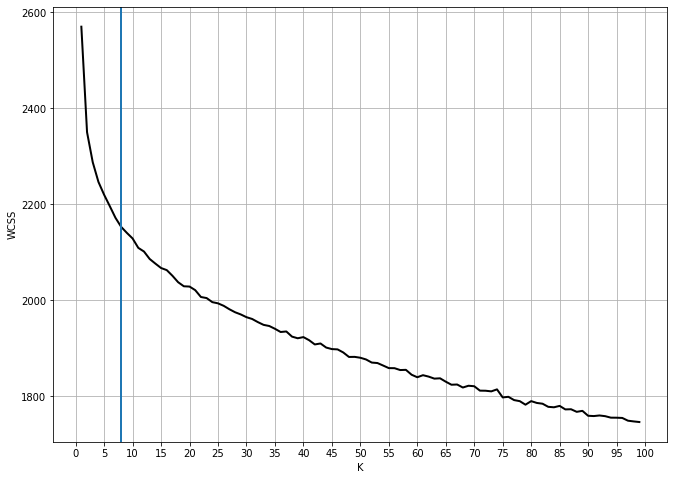

In [1007]:
plt.figure(figsize=(11,8))
plt.plot(range(1, 100), wcss, linewidth=2, color='black')
plt.axvline(x=8, linewidth=2)
plt.xticks(np.linspace(0,100,21))
plt.xlabel('K')
plt.ylabel('WCSS')
plt.grid(axis='both')
plt.show()

We choose k = 8 clusters, as it is a knee in the WCSS curve above.

In [1008]:
# Fitting of the kmeans model for 8 clusters

kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10, max_iter=100, random_state=88)
kmeans.fit(x_train)
wcss_train = kmeans.inertia_

In [1009]:
# We compute the centroid and the size of each cluster, which will be useful later

print('k-means center is: \n', kmeans.cluster_centers_)
kmeans_size = []
clusters = np.unique(kmeans.labels_)
for cluster in clusters:
    kmeans_size.append(len(np.where(kmeans.labels_ == cluster)[0]))
kmeans_size  

k-means center is: 
 [[ 1.66886546e-02 -4.52399483e-02 -1.98475466e-03 ... -1.58281687e-03
  -2.10225776e-02  3.64570467e-02]
 [-6.91319112e-02 -7.59399903e-02 -4.17256035e-02 ... -1.28761278e-02
  -3.78199814e-02 -3.70274057e-02]
 [ 1.85091911e-03  5.48941521e-03 -1.54929475e-02 ...  6.59621665e-03
  -7.37328460e-03 -9.99549614e-03]
 ...
 [ 6.97766059e-02  5.99528742e-02  2.98608045e-02 ...  4.51966322e-03
   2.87379871e-02  3.32891002e-02]
 [-6.14809192e-02 -6.45144949e-02 -3.67775292e-02 ...  5.85539873e-05
  -2.95185789e-02 -3.11825516e-02]
 [-6.10319463e-02 -6.65398438e-02 -3.56719631e-02 ... -7.01042643e-03
  -3.50427494e-02 -2.75475167e-02]]


[297, 327, 331, 346, 415, 494, 227, 154]

In [1010]:
# We had a column Cluster with the cluster number of each observation

df_train_cluster = df_train.copy()
df_train_cluster['Cluster'] = kmeans.labels_
df_train_cluster.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,V00P7RKFR_Monthly,...,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes,cumulative_outcome,Cluster
558,-0.062097,-0.076635,-0.038857,-0.045515,0.013989,0.049372,0.045718,0.061011,-0.114823,0.048948,-0.046763,0.194942,0.060504,0.075623,0.073174,0.112301,0.049547,0.122500,-0.079907,-0.053806,0.114831,-0.077616,-0.044744,-0.021484,-0.059395,-0.027900,-0.007144,-0.036485,0.109007,-0.022553,-0.051476,-0.030335,0.066268,-0.009857,-0.063714,-0.042479,0.097977,-0.020794,-0.050305,-0.058401,...,-0.016743,-0.001635,0.030702,-0.001635,-0.025542,-0.004008,-0.007691,-0.005177,-0.006756,-0.040301,0.014009,-0.022553,-0.003658,-0.032647,-0.006756,0.014206,-0.015701,-0.014401,-0.109007,-0.051810,0.212571,-0.022749,-0.030335,-0.066268,-0.071493,0.212571,-0.091611,-0.123263,-0.039760,-0.067913,-0.037793,-0.004008,-0.021620,-0.036532,-0.004910,-0.020083,-0.039307,0.238125,0,7
2651,-0.045562,-0.028329,-0.028510,-0.033396,-0.067725,-0.063276,-0.073748,-0.057636,-0.099013,-0.070973,-0.023668,-0.058030,-0.011726,-0.025021,0.098410,-0.056680,-0.083362,0.089881,-0.058629,-0.039478,-0.063220,-0.056949,-0.032829,-0.015763,0.122228,-0.020471,-0.005242,-0.026770,0.079981,-0.016547,0.141030,-0.022257,-0.109550,-0.007232,0.113941,-0.031167,-0.074096,-0.015257,-0.036910,-0.042850,...,-0.012285,-0.001200,-0.236458,-0.001200,0.284223,-0.002941,-0.005643,-0.003798,-0.004957,-0.029570,0.010279,-0.016547,-0.002684,-0.023954,-0.004957,0.010423,-0.011520,-0.010566,0.066598,-0.038014,-0.034152,0.319126,-0.022257,-0.048622,-0.052456,-0.034152,0.079244,0.058896,0.182587,-0.049829,-0.027730,-0.002941,-0.015863,-0.026805,-0.003603,-0.014736,-0.028840,-0.030487,0,3
2673,-0.080512,-0.089197,-0.045226,-0.052976,0.016282,0.018438,0.102910,0.026534,0.030303,-0.041937,0.255316,0.154827,0.112493,0.119345,0.024158,-0.045788,-0.047836,-0.094010,-0.093005,-0.062625,-0.100288,-0.090339,-0.052078,-0.025006,-0.069131,-0.032473,-0.008316,-0.042466,0.126876,-0.026250,-0.059914,-0.035307,0.077131,-0.011473,-0.074158,-0.049442,0.114037,-0.024202,-0.058551,-0.067974,...,-0.019488,-0.001903,0.035734,-0.001903,-0.029729,-0.004665,-0.008952,-0.006025,-0.007864,-0.046907,0.016305,-0.026250,-0.004258,-0.037998,-0.007864,0.016535,-0.018275,-0.016761,0.105646,-0.060302,-0.054176,-0.026477,-0.035307,0.173781,-0.083213,-0.054176,-0.106628,-0.143469,-0.046277,0.169573,-0.043988,-0.004665,-0.025164,-0.042521,-0.005715,-0.023375,-0.045750,-0.048362,0,6
3499,0.003663,0.007725,-0.027733,-0.032485,-0.046912,-0.037087,0.010086,-0.024047,-0.053227,-0.034380,-0.048255,-0.031292,-0.046180,0.062838,-0.093939,-0.055134,

In [1011]:
#df_train_cluster.loc[2909].values

## **Split into the different clusters**

We create one data set for each cluster, we split the observations according to which cluster it belongs. It will be useful to apply a model for each cluster.

In [1012]:
df_cluster_0 = df_train_cluster[df_train_cluster['Cluster'] == 0]
df_cluster_1 = df_train_cluster[df_train_cluster['Cluster'] == 1]
df_cluster_2 = df_train_cluster[df_train_cluster['Cluster'] == 2]
df_cluster_3 = df_train_cluster[df_train_cluster['Cluster'] == 3]
df_cluster_4 = df_train_cluster[df_train_cluster['Cluster'] == 4]
df_cluster_5 = df_train_cluster[df_train_cluster['Cluster'] == 5]
df_cluster_6 = df_train_cluster[df_train_cluster['Cluster'] == 6]
df_cluster_7 = df_train_cluster[df_train_cluster['Cluster'] == 7]

In [1013]:
df_cluster_0 = df_cluster_0.drop('Cluster', axis = 1)
df_cluster_1 = df_cluster_1.drop('Cluster', axis = 1)
df_cluster_2 = df_cluster_2.drop('Cluster', axis = 1)
df_cluster_3 = df_cluster_3.drop('Cluster', axis = 1)
df_cluster_4 = df_cluster_4.drop('Cluster', axis = 1)
df_cluster_5 = df_cluster_5.drop('Cluster', axis = 1)
df_cluster_6 = df_cluster_6.drop('Cluster', axis = 1)
df_cluster_7 = df_cluster_7.drop('Cluster', axis = 1)

In [1014]:
#df_train_cluster_0 = cluster_data(df_train_cluster, 0)
len(df_cluster_1)
df_cluster_0.head(10)

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,V00P7RKFR_Monthly,...,V00RELACV_Yes,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes,cumulative_outcome
1620,0.025892,-0.053191,-0.033648,-0.039414,0.058136,0.057594,0.081123,0.069378,-0.064581,-0.073251,-0.032520,-0.019766,0.100636,0.043973,0.006362,4.800466e-02,9.000236e-02,-0.069943,-0.069196,-0.046593,0.099438,0.110389,0.191490,-0.018604,-0.051433,-0.024160,-0.006187,-0.031594,-0.078600,-0.019530,-0.044576,-0.026268,0.057385,-0.008536,-0.055173,-0.036784,0.084843,-0.018006,-0.043562,-0.050573,...,-0.015354,-0.014499,-0.001416,0.026586,-0.001416,-0.022118,-0.003471,-0.006660,-0.004483,-0.005850,-0.034899,0.012131,-0.019530,-0.003168,-0.028271,-0.005850,0.012302,-0.013597,-0.012470,0.078600,-0.044865,-0.040306,-0.019699,-0.026268,0.129293,-0.061910,-0.040306,-0.079331,0.069510,-0.034430,-0.058809,-0.032727,-0.003471,-0.018722,0.234532,-0.004252,-0.017391,-0.034038,-0.035981,0
2191,0.023447,-0.014838,-0.024640,-0.028862,-0.007979,-0.032951,-0.026645,-0.016624,-0.098331,-0.069036,-0.004263,-0.032516,0.030450,-0.013747,-0.032445,4.270213e-17,-4.084163e-17,0.077678,0.078517,-0.034119,-0.054637,-0.049217,-0.028372,-0.013623,-0.037663,-0.017692,-0.004530,-0.023136,-0.057557,-0.014301,-0.032641,-0.019236,0.042021,-0.006250,-0.040402,-0.026936,0.062128,-0.013185,-0.031899,0.107430,...,-0.011243,-0.010617,-0.001037,0.019468,-0.001037,-0.016197,-0.002541,-0.004877,-0.003283,-0.004284,-0.025555,-0.447862,-0.014301,-0.002320,-0.020702,-0.004284,-0.441647,-0.009956,-0.009132,0.057557,-0.032853,-0.029515,-0.014425,0.206828,-0.042021,-0.045335,-0.029515,0.068486,0.050900,-0.025212,-0.043064,-0.023965,-0.002541,-0.013709,-0.023166,-0.003114,-0.012735,-0.024925,-0.026348,1
2754,0.001217,-0.029500,-0.007562,-0.034776,-0.029918,-0.000990,-0.040150,-0.051767,-0.056981,0.028123,0.063106,0.016483,-0.030433,-0.076672,-0.023260,-3.005725e-02,-3.140146e-02,-0.061712,0.094607,0.140501,-0.065834,0.097399,-0.034186,-0.016415,-0.045380,-0.021317,-0.005459,-0.027876,-0.069351,-0.017231,-0.039330,-0.023177,0.050632,-0.007531,-0.048681,-0.032456,0.074859,-0.015887,-0.038436,0.129445,...,-0.013547,-0.012793,-0.001249,0.023458,-0.001249,-0.019515,-0.003062,-0.005876,-0.003955,-0.005162,0.187582,0.010704,-0.017231,-0.002795,-0.024944,-0.005162,0.010854,-0.011997,-0.011003,-0.083287,0.145914,-0.035563,-0.017381,-0.023177,-0.050632,0.105740,-0.035563,0.082520,0.061330,-0.030379,-0.051889,-0.028876,-0.003062,-0.016519,-0.027912,-0.003752,-0.015345,-0.030032,-0.031747,0
2582,0.087363,-0.046737,-0.029565,-0.034631,-0.009575,0.025093,0.010753,0.003439,0.050431,-0.055126,-0.0

In [1015]:
#print(df_train_cluster_0['cumulative_outcome'])

In [1016]:
print(len(df_cluster_0), len(df_cluster_1), len(df_cluster_2), len(df_cluster_3), len(df_cluster_4), len(df_cluster_5), len(df_cluster_6), len(df_cluster_7))

297 327 331 346 415 494 227 154


In [1017]:
print(len(df_cluster_0.columns), len(df_cluster_1.columns), len(df_cluster_2.columns), len(df_cluster_3.columns), len(df_cluster_4.columns), len(df_cluster_5.columns), len(df_cluster_6.columns), len(df_cluster_7.columns))

228 228 228 228 228 228 228 228


## Logistic Regression: training

We choose to apply a logistic regression model as it is the one which has the best performance among the model that we did before. We will train one model for each cluster.

### Cluster 0

In [1018]:
print(np.linalg.matrix_rank(df_cluster_0))

183


We will use sklearn as a library for the logistic regression model, because our dataframes are not invertible matrix, and sklearn can handle it.

In [1019]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_0 = df_cluster_0.drop('cumulative_outcome', axis='columns')
y_train_cluster_0 = df_cluster_0['cumulative_outcome']

logreg0 = LogisticRegression()
logreg0.fit(x_train_cluster_0, y_train_cluster_0.ravel())
print('Accuracy = ', logreg0.score(x_train_cluster_0, y_train_cluster_0.ravel()))

Accuracy =  0.7542087542087542


In [1020]:
# We create a list with the accuracy of each cluster to analyze it later
Accuracy_train = []
Accuracy_train.append(logreg0.score(x_train_cluster_0, y_train_cluster_0.ravel()))

In [1021]:
## Coefficients of the logistic regression
logreg0.coef_

array([[ 1.39222375e-01, -1.23004859e-01,  2.35835486e-02,
         3.08020079e-01, -2.07616960e-01,  9.99436309e-02,
         4.08202312e-02,  2.76164301e-01, -4.61090499e-01,
        -3.19480732e-01, -1.28648742e-01,  3.65021573e-01,
        -4.36454488e-01,  2.81718164e-01,  2.45292835e-01,
        -9.55878264e-02,  7.66807918e-02, -2.11671981e-01,
        -1.20264298e-01, -2.15421403e-01,  4.26039321e-01,
         6.49420590e-01,  1.29928639e-01,  9.05589847e-02,
        -4.37634639e-02, -3.65211922e-01,  1.42539947e-03,
         2.20177445e-01, -5.40297314e-01,  5.13581684e-02,
        -7.84557207e-02,  6.05213116e-03,  6.52687634e-02,
         1.96659836e-03, -2.44738075e-01, -1.11835524e-01,
         3.01258042e-01,  4.14854598e-03,  5.96100121e-02,
        -2.39316089e-01, -3.19099224e-02,  2.38695235e-01,
        -1.03438760e-02,  2.22605800e-03,  9.36711175e-03,
        -1.12560399e-01, -3.45379512e-03, -1.25572212e-01,
         7.87528043e-02,  2.48170019e-03, -1.84189859e-0

In [1022]:
## Computation of the p-values of the features, to perform features selection later
import statsmodels.api as sm
mod0 = sm.OLS(y_train_cluster_0,x_train_cluster_0)
fii0 = mod0.fit()
p_values0 = fii.summary2().tables[1]['P>|t|']
p_values0

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 1: Training

In [1023]:
## Logistic Regression with sklearn

x_train_cluster_1 = df_cluster_1.drop('cumulative_outcome', axis='columns')
y_train_cluster_1 = df_cluster_1['cumulative_outcome']

logreg1 = LogisticRegression()
logreg1.fit(x_train_cluster_1, y_train_cluster_1.ravel())
print('Accuracy = ', logreg1.score(x_train_cluster_1, y_train_cluster_1.ravel()))

Accuracy =  0.7400611620795107


In [1024]:
Accuracy_train.append(logreg1.score(x_train_cluster_1, y_train_cluster_1.ravel()))

In [1025]:
## Coefficients of the logistic regression
logreg1.coef_

array([[ 1.16524432e-01, -9.13812496e-03,  6.50551406e-04,
        -7.64911841e-03, -5.33054310e-01, -3.14173876e-01,
        -5.55627771e-01,  2.23396436e-01, -2.43692261e-01,
        -1.26258567e-02, -2.67180233e-01, -3.83685327e-01,
        -2.55194938e-01, -1.43922234e-01, -2.95793584e-01,
        -8.75224679e-02,  1.73411355e-01, -1.67441484e-01,
         3.96366964e-01, -7.04799940e-02,  3.25926451e-01,
        -1.62600046e-01,  6.82702282e-01,  4.81108907e-01,
         5.82293664e-01,  3.84912932e-01,  2.04317123e-03,
         7.18174522e-02, -8.16632863e-01,  6.95240252e-01,
         3.63035451e-02,  8.67514019e-03, -3.80439794e-02,
         2.81892709e-03, -2.43365388e-01, -5.09030152e-02,
         2.55177523e-01,  5.94653635e-03,  1.43863545e-02,
         1.37899202e-01,  8.37860045e-02, -2.66052265e-01,
         1.75249286e-02,  3.19083719e-03,  2.84841280e-02,
        -6.67815223e-02, -1.94942854e-01,  9.03161131e-03,
         1.66355066e-01,  3.55727536e-03, -2.11422099e-0

In [1026]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod1 = sm.OLS(y_train_cluster_1,x_train_cluster_1)
fii1 = mod1.fit()
p_values1 = fii.summary2().tables[1]['P>|t|']
p_values1

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 2: Training

In [1027]:
## Logistic Regression with sklearn

x_train_cluster_2 = df_cluster_2.drop('cumulative_outcome', axis='columns')
y_train_cluster_2 = df_cluster_2['cumulative_outcome']

logreg2 = LogisticRegression()
logreg2.fit(x_train_cluster_2, y_train_cluster_2.ravel())
print('Accuracy = ', logreg2.score(x_train_cluster_2, y_train_cluster_2.ravel()))

Accuracy =  0.7069486404833837


In [1028]:
Accuracy_train.append(logreg2.score(x_train_cluster_2, y_train_cluster_2.ravel()))

In [1029]:
## Coefficients of the logistic regression
logreg2.coef_

array([[-2.00402107e-01,  6.56619578e-02,  8.83331617e-02,
         1.35970781e-01, -8.73048877e-01, -3.83702474e-01,
         1.71937294e-01, -3.07576717e-01, -1.72240023e-01,
         1.94630853e-02,  2.53088711e-01, -3.97607200e-01,
        -4.54022144e-01,  8.49054074e-01, -1.03205526e+00,
        -2.63595164e-01, -2.78338850e-01, -3.77348158e-01,
        -4.38306563e-01,  7.11769752e-03,  2.73593468e-01,
         2.75810341e-01, -4.90331103e-01,  5.10645137e-01,
         4.91384030e-01, -5.44876208e-01, -1.28969684e-03,
        -5.21256554e-01, -3.52675105e-01, -8.52805322e-02,
        -5.02732774e-01, -1.20398008e-02,  4.52446898e-01,
        -1.77937185e-03, -2.98485992e-01, -5.84300056e-02,
         3.46653920e-01, -8.25676544e-02, -2.54360159e-01,
         4.25663761e-01, -1.47977937e-01, -3.87081597e-02,
         1.63249264e-01, -2.01413009e-03, -6.84296575e-01,
         1.79631627e-01,  3.37022353e-02,  1.88194714e-01,
        -1.96881594e-01,  2.01869005e-01, -7.75001659e-0

In [1030]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod2 = sm.OLS(y_train_cluster_2,x_train_cluster_2)
fii2 = mod2.fit()
p_values2 = fii.summary2().tables[1]['P>|t|']
p_values2

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 3: Training

In [1031]:
## Logistic Regression with sklearn

x_train_cluster_3 = df_cluster_3.drop('cumulative_outcome', axis='columns')
y_train_cluster_3 = df_cluster_3['cumulative_outcome']

logreg3 = LogisticRegression()
logreg3.fit(x_train_cluster_3, y_train_cluster_3.ravel())
print('Accuracy = ', logreg3.score(x_train_cluster_3, y_train_cluster_3.ravel()))

Accuracy =  0.7832369942196532


In [1032]:
Accuracy_train.append(logreg3.score(x_train_cluster_3, y_train_cluster_3.ravel()))

In [1033]:
## Coefficients of the logistic regression
logreg3.coef_

array([[ 0.15222227, -0.01291461, -0.16989793,  0.09497085, -0.79897101,
        -0.08909227,  0.19523345, -0.01450771, -0.0632383 ,  0.05744524,
         0.27201943,  0.40736777,  0.72343072,  0.48821612,  0.60221453,
        -0.04250753, -0.44785716,  0.01492169,  0.0482295 , -0.36486817,
         0.62415724,  0.16989762, -0.13698212,  0.73505391,  0.61416334,
         0.23672655,  0.39857176,  0.81104823, -0.21144243,  0.5390284 ,
        -0.37328352,  0.75202681, -0.23872771,  0.34585163, -0.21106139,
        -0.44746085,  0.29520768,  0.60398974,  0.15577124, -0.25646265,
        -0.06389761,  0.11362505, -0.05313398,  0.47977948, -0.27716797,
        -0.6538812 , -0.02951153, -0.1293954 , -0.07027502,  0.54833588,
         0.68184759, -0.18973791, -0.52383204, -0.2385236 ,  0.29421369,
        -0.13777259, -0.24450387,  0.35768045,  0.00550698,  0.06739823,
        -0.05437136,  0.0314106 ,  0.18115186,  0.09768538, -0.24905579,
         0.04779136, -0.1360402 ,  0.09850416, -0.2

In [1034]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod3 = sm.OLS(y_train_cluster_3,x_train_cluster_3)
fii3 = mod3.fit()
p_values3 = fii.summary2().tables[1]['P>|t|']
p_values3

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 4: Training

In [1035]:
## Logistic Regression with sklearn

x_train_cluster_4 = df_cluster_4.drop('cumulative_outcome', axis='columns')
y_train_cluster_4 = df_cluster_4['cumulative_outcome']

logreg4 = LogisticRegression()
logreg4.fit(x_train_cluster_4, y_train_cluster_4.ravel())
print('Accuracy = ', logreg4.score(x_train_cluster_4, y_train_cluster_4.ravel()))

Accuracy =  0.7614457831325301


In [1036]:
Accuracy_train.append(logreg4.score(x_train_cluster_4, y_train_cluster_4.ravel()))

In [1037]:
## Coefficients of the logistic regression
logreg4.coef_

array([[ 2.13494685e-01,  3.77873162e-01,  2.18580024e-02,
        -1.85752228e-01, -2.11801467e-02, -2.20374256e-01,
         8.40732892e-02, -4.04060877e-02, -5.71851636e-01,
         4.52604591e-01, -2.53694492e-01,  4.38593459e-01,
        -5.11091227e-01,  7.70681102e-01,  1.90777355e-01,
         1.73593334e-01, -1.55004238e-02, -6.64641425e-01,
         3.50298372e-01,  2.61011257e-01, -3.08346160e-01,
         1.17889105e+00, -1.40647726e-01, -2.79137609e-01,
         6.59664135e-02, -6.78735388e-01, -1.70542895e-01,
         6.96338382e-01, -8.88060883e-01,  1.75192000e-01,
        -4.49386421e-01, -2.89360653e-02,  4.14704530e-01,
         1.38832461e-03,  9.61280338e-02,  1.01542133e-01,
        -1.62013459e-01,  2.92867552e-03, -2.47870876e-01,
         1.41526412e-01,  3.38636363e-01, -2.09092151e-01,
        -1.14306114e-01,  1.57149074e-03,  2.87783057e-01,
        -2.60570015e-01, -2.65693292e-02,  1.25868311e-01,
        -9.09212159e-02,  1.45129577e-01, -2.74202453e-0

In [1038]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod4 = sm.OLS(y_train_cluster_4,x_train_cluster_4)
fii4 = mod4.fit()
p_values4 = fii.summary2().tables[1]['P>|t|']
p_values4

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 5: Training

In [1039]:
## Logistic Regression with sklearn

x_train_cluster_5 = df_cluster_5.drop('cumulative_outcome', axis='columns')
y_train_cluster_5 = df_cluster_5['cumulative_outcome']

logreg5 = LogisticRegression()
logreg5.fit(x_train_cluster_5, y_train_cluster_5.ravel())
print('Accuracy = ', logreg5.score(x_train_cluster_5, y_train_cluster_5.ravel()))

Accuracy =  0.7226720647773279


In [1040]:
Accuracy_train.append(logreg5.score(x_train_cluster_5, y_train_cluster_5.ravel()))

In [1041]:
## Coefficients of the logistic regression
logreg5.coef_

array([[ 0.45286626, -0.12767409, -0.1855959 , -0.51129373,  0.40008584,
         0.07525755, -0.19155081, -0.28775398,  0.44826567, -0.00884279,
         0.16273168,  0.18065849,  0.16400087,  0.54086787,  0.32018528,
        -0.28597249, -0.3638088 , -0.69470225,  0.11405321, -0.46224979,
        -0.07026457, -0.21056297,  0.12167148,  0.22423481,  0.43413994,
         0.53478925,  0.78193503, -0.41007259,  0.11339178,  0.3307658 ,
        -0.50529942,  0.44382192,  0.08569345,  0.39675516,  0.01753221,
        -0.24904895, -0.2074535 ,  0.38839615, -0.04796672, -0.05392646,
         0.24799221, -0.51815622,  0.31286338,  0.38596427, -0.20489169,
         0.00893264, -0.28109293, -0.06630699,  0.36790305,  0.00212043,
         0.46821311, -0.88058316, -0.01257985,  0.41010689, -0.1734156 ,
         0.06161137,  0.19247629, -0.43563738,  0.251328  , -0.05766713,
        -0.38740149,  0.52035152, -0.34599105,  0.23586656, -0.24750933,
         0.54586836, -0.09715624, -0.38904507,  0.1

In [1042]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod5 = sm.OLS(y_train_cluster_5,x_train_cluster_5)
fii5 = mod5.fit()
p_values5 = fii.summary2().tables[1]['P>|t|']
p_values5

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 6: Training

In [1043]:
## Logistic Regression with sklearn

x_train_cluster_6 = df_cluster_6.drop('cumulative_outcome', axis='columns')
y_train_cluster_6 = df_cluster_6['cumulative_outcome']

logreg6 = LogisticRegression()
logreg6.fit(x_train_cluster_6, y_train_cluster_6.ravel())
print('Accuracy = ', logreg6.score(x_train_cluster_6, y_train_cluster_6.ravel()))

Accuracy =  0.7048458149779736


In [1044]:
Accuracy_train.append(logreg6.score(x_train_cluster_6, y_train_cluster_6.ravel()))

In [1045]:
## Coefficients of the logistic regression
logreg6.coef_

array([[-1.69366502e-03, -1.71462874e-02, -3.94245807e-04,
        -5.63182592e-01, -3.28767749e-01, -2.40417868e-01,
         2.31751344e-01, -1.58582280e-01,  9.21856648e-03,
        -5.44523046e-01, -2.02433209e-01, -3.08988625e-01,
         3.46699379e-01,  2.40749107e-01, -3.09631408e-01,
         7.68410367e-01,  3.41936173e-01,  6.25128213e-02,
        -3.39244723e-01,  1.16525757e-01, -2.34528404e-01,
         2.16388282e-01,  5.13360563e-01, -9.99907136e-02,
         8.24872344e-02, -3.14008043e-01, -7.78921179e-04,
        -2.97757741e-01, -5.09550791e-01,  1.91246627e-01,
         9.89915772e-02, -3.30723648e-03, -8.53113725e-02,
        -1.07466373e-03,  4.93581127e-01,  1.16933228e-01,
        -5.31861044e-01, -2.26700682e-03, -1.29847494e-01,
         4.07167790e-01, -2.44344155e-01, -2.85088683e-02,
        -1.72049450e-01, -1.21644757e-03,  7.71311903e-02,
         7.48543775e-02,  1.44496764e-01, -3.44313449e-03,
        -1.25695883e-01, -1.35614533e-03,  1.17444207e-0

In [1046]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod6 = sm.OLS(y_train_cluster_6,x_train_cluster_6)
fii6 = mod6.fit()
p_values6 = fii.summary2().tables[1]['P>|t|']
p_values6

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

### Cluster 7: Training

In [1047]:
## Logistic Regression with sklearn

x_train_cluster_7 = df_cluster_7.drop('cumulative_outcome', axis='columns')
y_train_cluster_7 = df_cluster_7['cumulative_outcome']

logreg7 = LogisticRegression()
logreg7.fit(x_train_cluster_7, y_train_cluster_7.ravel())
print('Accuracy = ',logreg7.score(x_train_cluster_7, y_train_cluster_7.ravel()))

Accuracy =  0.7337662337662337


In [1048]:
Accuracy_train.append(logreg7.score(x_train_cluster_7, y_train_cluster_7.ravel()))

In [1049]:
## Coefficients of the logistic regression
logreg7.coef_

array([[ 0.1408727 ,  0.19222347,  0.21111394,  0.03854913,  0.2698563 ,
        -0.0448699 ,  0.24515991,  0.01232008, -0.01705201,  0.67313005,
        -0.34003229, -0.27139969,  0.14506051,  0.49888018, -0.53692493,
         0.19684381,  0.39482   , -0.02057835, -0.16934771,  0.21573129,
         0.83986522,  0.01149528,  0.01518505, -0.19930721,  0.51113901,
         0.08147762,  0.00706956,  0.32791319, -0.7393787 ,  0.48141261,
        -0.04663204,  0.03001676,  0.05331872, -0.14343583,  0.4728237 ,
        -0.00801118, -0.43307041,  0.02057555, -0.00320854, -0.53015363,
         0.63911871, -0.30145528,  0.05710126,  0.01104058, -0.1074985 ,
         0.02333486,  0.2809983 ,  0.03125018, -0.27232018,  0.01230849,
        -0.25602105, -0.02407774,  0.23601977,  0.01665113,  0.0163018 ,
         0.02166034, -0.0271805 ,  0.00648483,  0.24622155,  0.23820918,
        -0.35461494,  0.01263344, -0.06514589,  0.03758012,  0.02399368,
         0.01922184,  0.11855154, -0.59052725,  0.5

In [1050]:
## p-values of the logistic regression to perform features selection
import statsmodels.api as sm
mod7 = sm.OLS(y_train_cluster_7,x_train_cluster_7)
fii7 = mod7.fit()
p_values7 = fii.summary2().tables[1]['P>|t|']
p_values7

V00WOMTSL                           0.422254
V00WOMTSR                           0.594368
P01KPACDCV                          0.490362
V00COMORB                           0.441689
V00HT25MM                           0.407957
                                      ...   
V00LKEFFB_Yes                       0.573021
V00LKEFFPT_Too_tender_to_examine    0.602212
V00LKEFFPT_Yes                      0.278842
V00RKRFXPN_Yes                      0.911536
V00LKRFXPN_Yes                      0.144860
Name: P>|t|, Length: 227, dtype: float64

# **Logistic Regression: Test**
For each observation of the test data set, we are going to assign a cluster, according to which cluster the observation is the closest, and then to apply the logistic regression model of this specific cluster. 

In [1051]:
len(x_test)

1111

In [1052]:
## Assign each point of the test set to a cluster
from tqdm import tqdm

Clusters_test = pd.DataFrame(data = len(x_test)*[0], index = x_test.index, columns = ['Cluster'])
for i in tqdm(range(len(x_test))):
  dist_clusters = 8*[0] #First element will be the distance to the first cluster, second element to the second, ...
  for j in range(227):
    for k in range(8):
      #We use a metric to compute the distance between tow points, that we sum for each point of the vector
      dist_clusters[k] = dist_clusters[k] + (x_test.iloc[i,j] - kmeans.cluster_centers_[k][j])**2
  #We select the cluster for which the distance between the observation and the centroid is minimal
  K = dist_clusters.index(min(dist_clusters))
  Clusters_test.iloc[i,0] = K

100%|██████████| 1111/1111 [00:56<00:00, 19.61it/s]


In [1053]:
## Number of observations in each cluster

Clusters_test['Cluster'].value_counts()

5    235
4    164
2    145
1    139
3    133
0    119
6    105
7     71
Name: Cluster, dtype: int64

In [1054]:
## We split the observation according to the cluster it belongs to
## Then, the aim is to predict the outcomes of one data set using the specific model of the cluster involved

df_test_cluster_0 = df_test[Clusters_test['Cluster'] == 0]
df_test_cluster_1 = df_test[Clusters_test['Cluster'] == 1]
df_test_cluster_2 = df_test[Clusters_test['Cluster'] == 2]
df_test_cluster_3 = df_test[Clusters_test['Cluster'] == 3]
df_test_cluster_4 = df_test[Clusters_test['Cluster'] == 4]
df_test_cluster_5 = df_test[Clusters_test['Cluster'] == 5]
df_test_cluster_6 = df_test[Clusters_test['Cluster'] == 6]
df_test_cluster_7 = df_test[Clusters_test['Cluster'] == 7]

In [1055]:
# We check the len of each created data sets
print(len(df_test_cluster_0), len(df_test_cluster_1), len(df_test_cluster_2), len(df_test_cluster_3), len(df_test_cluster_4), len(df_test_cluster_5), len(df_test_cluster_6), len(df_test_cluster_7))

119 139 145 133 164 235 105 71


In [1056]:
df_test_cluster_0.head()

,V00WOMTSL,V00WOMTSR,P01KPACDCV,V00COMORB,V00HT25MM,V00WT25KG,V00WTMAXKG,V00WTMINKG,V00BPDIAS,V00BPSYS,V00DTVITD,V00DTCALC,V00DTCHOL,P01BMI,V00PASE,V00LLWGT,V00RLWGT,P01KPNREV_Yes,P01KPNLEV_Yes,P01KPACT30_Yes,P01HPNR12_Yes,P01HPNL12_Yes,V00SF2_Yes__limited_a_little,V00SF2_Yes__limited_a_lot,V00SF3_Yes__limited_a_little,V00SF3_Yes__limited_a_lot,V00SF8_Extremely,V00SF8_Moderately,V00SF8_Not_at_all,V00SF8_Quite_a_bit,V00WPRKN1_Mild,V00WPRKN1_Moderate,V00WPRKN1_None,V00WPRKN1_Severe,V00WPRKN2_Mild,V00WPRKN2_Moderate,V00WPRKN2_None,V00WPRKN2_Severe,V00P7RKFR_Daily,V00P7RKFR_Monthly,...,V00RELACV_Yes,V00SPIRCV_Yes,P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds,P01RASTASV_Does_not_report_RA_inflam_arth,P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_to_all_meds,P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds,P02KSURGCV_Yes,V00OTHCAMC_Yes,V00OTHCAM_Yes,V00DISCOMF_Yes,V00LFXCOMP_Yes,V00LFXPN_Yes,V00EKRSL_Yes,V00REXPN_Yes,V00EKRSR_Yes,V00RFXCOMP_Yes,V00VITDCV_4_6_days_per_week,V00VITDCV_A_few_days_per_month,V00VITDCV_Didn_t_take,V00VITDCV_Every_day,V00VITDCV_No_vitamins_minerals_taken_in_past_year,V00CALCMCV_4_6_days_per_week,V00CALCMCV_A_few_days_per_month,V00CALCMCV_Didn_t_take,V00CALCMCV_Every_day,V00CALCMCV_No_vitamins_minerals_taken_in_past_year,V00VIT9_Yes,V00VIT1_Yes,P01FAMKR_Yes,P02WTGA_Yes,V00RKEFFB_Yes,V00RKEFFPT_Too_tender_to_examine,V00RKEFFPT_Yes,V00LKEFFB_Yes,V00LKEFFPT_Too_tender_to_examine,V00LKEFFPT_Yes,V00RKRFXPN_Yes,V00LKRFXPN_Yes,cumulative_outcome
1732,-0.007473,-0.013923,-0.023121,-0.027083,0.087381,0.112286,6.687924e-02,0.168777,0.075359,0.036349,0.014777,0.000035,-0.027968,0.040070,-0.076141,-0.023408,-0.035242,-0.048060,0.073677,-0.032015,0.068327,-0.046183,-0.026623,-0.012783,-0.035341,-0.016601,-0.004251,-0.021709,0.064862,-0.013419,0.114370,-0.018050,-0.088841,-0.005865,0.092402,-0.025276,-0.060089,-0.012373,-0.029933,0.100808,...,-0.010550,-0.009963,-0.000973,0.018268,-0.000973,-0.015198,-0.002385,-0.004576,-0.003080,-0.004020,-0.023980,0.008336,-0.013419,-0.002177,-0.019426,-0.004020,0.008453,-0.009343,-0.008569,0.054008,-0.030828,-0.027696,-0.013536,-0.018050,0.088841,-0.042540,-0.027696,-0.054511,-0.073344,0.148071,0.086690,-0.022488,-0.002385,-0.012864,-0.021737,-0.002922,-0.011950,-0.023388,-0.024724,0
2080,0.062570,-0.049925,-0.028103,-0.032918,0.048555,0.028702,-3.419796e-02,0.057944,-0.126705,-0.061179,0.041207,0.112400,-0.055354,-0.053112,0.104057,-0.028452,-0.003501,0.088597,0.089554,-0.038914,-0.062317,-0.056135,-0.032360,-0.015538,-0.042957,-0.020178,-0.005167,-0.026388,0.078838,-0.016311,-0.037230,-0.021939,0.047928,-0.007129,-0.046081,-0.030722,0.070861,-0.015039,-0.036383,-0.042238,...,-0.012823,-0.012109,-0.001183,0.022205,-0.001183,-0.018473,-0.002899,-0.005562,-0.003744,-0.004886,-0.029147,0.010132,-0.016311,-0.002646,-0.023611,-0.004886,0.010274,-0.011356,-0.010415,0.065647,-0.037471,-0.033664,-0.016453,-0.021939,0.107985,-0.051707,-0.033664,-0.066257,-0.089149,-0.028756,-0.049117,-0.027334,-0.002899,-0.015636,-0.026422,-0.003551,-0.014525,-0.028428,0.172221,0
3065,0.039535,-0.056148,-0.028469,0.057803,-0.028689,0.172655,1.827031e-16,-0.052076,0.107535,0.035863,-0.021576,-0.026806,-0.073959,0.088777,-0.014266,0.026728,0.023019,-0.059178,0.090721,-0.039422,-0.063130,-0.056867,-0.032782,-0.015741,-0.043517,-0.020441,-0.005235,-0.026732,-0.066503,-0.016524,-0.037715,-0.022225,0.048553,-0.007222,-0.046682,-0.031123,0.071785,-0.015235,-0.036857,-0.042789,...,-0.012991,-0.012267,-0.001198,0.022494,-0.001198,-0.018714,-0.002936,-0.005635,-0.003793,-0.004950,-0.029527,0.010264,-0.016524,-0.002680,-0.023919,-0.004950,0.010408,-0.011504,-0.010551,-0.079867,-0.037959,0.155745,-0.016667,-0.022225,-0.048553,-0.052381,0.155745,-0.067121,-0.090312,-0.029131,0.106744,-0.027690,-0.002936,-0.015840,-0.026766,-0.003598,-0.014714,-0.028799,0.174467,0
1906,0.042137,-0.029830,-0.025081,-0.029378,0.026181,-0.022479,-3.391787e-02,-0.021748,0.042781,0.015922,-0.045740,0.10145

Then, we are going to predict the outcomes for each cluster, using the models trained before. We assess its performance by computing the accuracy.

### Cluster 0

In [1057]:
x_test_cluster_0 = df_test_cluster_0.drop('cumulative_outcome', axis='columns')
y_test_cluster_0 = df_test_cluster_0['cumulative_outcome']

logreg0.predict(x_test_cluster_0)
print('Accuracy = ',logreg0.score(x_test_cluster_0, y_test_cluster_0.ravel()))

Accuracy =  0.5966386554621849


In [1058]:
#We create a list with the accuracy of each cluster to analyze it further
Accuracy_test = []
Accuracy_test.append(logreg0.score(x_test_cluster_0, y_test_cluster_0.ravel()))

### Cluster 1

In [1059]:
x_train_cluster_1.shape

(327, 227)

In [1060]:
x_test_cluster_1 = df_test_cluster_1.drop('cumulative_outcome', axis='columns')
y_test_cluster_1 = df_test_cluster_1['cumulative_outcome']

logreg1.predict(x_test_cluster_1)
print('Accuracy = ', logreg1.score(x_test_cluster_1, y_test_cluster_1.ravel()))

Accuracy =  0.6258992805755396


In [1061]:
Accuracy_test.append(logreg1.score(x_test_cluster_1, y_test_cluster_1.ravel()))

### Cluster 2

In [1062]:
x_test_cluster_2 = df_test_cluster_2.drop('cumulative_outcome', axis='columns')
y_test_cluster_2 = df_test_cluster_2['cumulative_outcome']

logreg2.predict(x_test_cluster_2)
print('Accuracy = ',logreg2.score(x_test_cluster_2, y_test_cluster_2.ravel()))

Accuracy =  0.5724137931034483


In [1063]:
Accuracy_test.append(logreg2.score(x_test_cluster_2, y_test_cluster_2.ravel()))

### Cluster 3

In [1064]:
x_test_cluster_3 = df_test_cluster_3.drop('cumulative_outcome', axis='columns')
y_test_cluster_3 = df_test_cluster_3['cumulative_outcome']

logreg3.predict(x_test_cluster_3)
print('Accuracy = ',logreg3.score(x_test_cluster_3, y_test_cluster_3.ravel()))

Accuracy =  0.6090225563909775


In [1065]:
Accuracy_test.append(logreg3.score(x_test_cluster_3, y_test_cluster_3.ravel()))

### Cluster 4

In [1066]:
x_test_cluster_4 = df_test_cluster_4.drop('cumulative_outcome', axis='columns')
y_test_cluster_4 = df_test_cluster_4['cumulative_outcome']

logreg4.predict(x_test_cluster_4)
print('Accuracy = ',logreg4.score(x_test_cluster_4, y_test_cluster_4.ravel()))

Accuracy =  0.524390243902439


In [1067]:
Accuracy_test.append(logreg4.score(x_test_cluster_4, y_test_cluster_4.ravel()))

### Cluster 5

In [1068]:
x_test_cluster_5 = df_test_cluster_5.drop('cumulative_outcome', axis='columns')
y_test_cluster_5 = df_test_cluster_5['cumulative_outcome']

logreg5.predict(x_test_cluster_5)
print('Accuracy = ', logreg5.score(x_test_cluster_5, y_test_cluster_5.ravel()))

Accuracy =  0.5702127659574469


In [1069]:
Accuracy_test.append(logreg5.score(x_test_cluster_5, y_test_cluster_5.ravel()))

### Cluster 6

In [1070]:
x_test_cluster_6 = df_test_cluster_6.drop('cumulative_outcome', axis='columns')
y_test_cluster_6 = df_test_cluster_6['cumulative_outcome']

logreg6.predict(x_test_cluster_6)
print('Accuracy = ', logreg6.score(x_test_cluster_6, y_test_cluster_6.ravel()))

Accuracy =  0.6571428571428571


In [1071]:
Accuracy_test.append(logreg6.score(x_test_cluster_6, y_test_cluster_6.ravel()))

### Cluster 7

In [1072]:
x_test_cluster_7 = df_test_cluster_7.drop('cumulative_outcome', axis='columns')
y_test_cluster_7 = df_test_cluster_7['cumulative_outcome']

logreg7.predict(x_test_cluster_7)
print('Accuracy = ',logreg7.score(x_test_cluster_7, y_test_cluster_7.ravel()))

Accuracy =  0.7464788732394366


In [1073]:
Accuracy_test.append(logreg7.score(x_test_cluster_7, y_test_cluster_7.ravel()))

### Summary

In [1074]:
summary1 = pd.DataFrame(data = [Accuracy_train, Accuracy_test], 
                        index = ['Accuracy_train', 'Accuracy_test'],
                        columns = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7'])
summary1

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
Accuracy_train,0.754209,0.740061,0.706949,0.783237,0.761446,0.722672,0.704846,0.733766
Accuracy_test,0.596639,0.625899,0.572414,0.609023,0.524390,0.570213,0.657143,0.746479


# Features selection

As we have a huge difference between the accuracy on the training and the testing data, we are going to perform features selection to reduce the overfitting of the training data.

## Cluster 0

### Feature selection: coefficients value
We are going to remove the features which have a coefficient value too low

In [1075]:
#We look for the columns which have low coefficients' values

low_coef_col = []
for i in range(len(logreg0.coef_[0])):
  if abs(logreg0.coef_[0][i]) < 0.1:
    low_coef_col.append(df_cluster_0.iloc[:,i].name)
print(len(low_coef_col))
print(low_coef_col)

71
['P01KPACDCV', 'V00WT25KG', 'V00WTMAXKG', 'V00LLWGT', 'V00RLWGT', 'V00SF2_Yes__limited_a_lot', 'V00SF3_Yes__limited_a_little', 'V00SF8_Extremely', 'V00SF8_Quite_a_bit', 'V00WPRKN1_Mild', 'V00WPRKN1_Moderate', 'V00WPRKN1_None', 'V00WPRKN1_Severe', 'V00WPRKN2_Severe', 'V00P7RKFR_Daily', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Often', 'V00KSXRKN1_Rarely', 'V00DIRKN1_Mild', 'V00DIRKN1_None', 'V00DIRKN1_Severe', 'V00DIRKN2_Severe', 'V00DIRKN14_Moderate', 'V00DIRKN14_Severe', 'V00WPLKN1_Mild', 'V00WPLKN2_None', 'V00WPLKN2_Severe', 'V00DILKN14_Severe', 'P02KPNRCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01KPA30CV_Yes', 'V00P7RKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7RKRCV_7', 'V00P7RKRCV_8', 'V00P7RKRCV_9', 'V00P7LKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7LKRCV_3', 'V00P7LKRCV_9', 'P01PMRKRCV_3', 'P01PMRKRCV_4', 'P01PMRKRCV_7', 'P01PMRKRCV_9', 'P01PMRKRCV_No_pain', 'P01PMLKRCV_2', 'P01BL12SXR_Neither', 'P01BL12SXR_SV_only', 'P01KPMED_Yes', 'P01

In [1076]:
# And we remove those features from the dataset

df2_cluster0 = df_cluster_0.copy()
for col in low_coef_col:
  df2_cluster0 = df2_cluster0.drop(col, axis = 1)
df2_cluster0.shape

(297, 157)

**Training**

In [1077]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_0_2 = df2_cluster0.drop('cumulative_outcome', axis='columns')
y_train_cluster_0_2 = df2_cluster0['cumulative_outcome']

logreg0_2 = LogisticRegression()
logreg0_2.fit(x_train_cluster_0_2, y_train_cluster_0_2.ravel())
logreg0_2.score(x_train_cluster_0_2, y_train_cluster_0_2.ravel())

0.7474747474747475

**Testing**

In [1078]:
# And we remove the features from the dataset

df2_test_cluster0 = df_test_cluster_0.copy()
for col in low_coef_col:
  df2_test_cluster0 = df2_test_cluster0.drop(col, axis = 1)
df2_test_cluster0.shape

(119, 157)

In [1079]:
#Predictions

x_test_cluster_0_2 = df2_test_cluster0.drop('cumulative_outcome', axis='columns')
y_test_cluster_0_2 = df2_test_cluster0['cumulative_outcome']

logreg0_2.predict(x_test_cluster_0_2)
logreg0_2.score(x_test_cluster_0_2, y_test_cluster_0_2)

0.5966386554621849

In [1080]:
## Coefficients of the logistic regression
logreg0_2.coef_

array([[ 0.13780324, -0.12352875,  0.31309742, -0.1820646 ,  0.30969361,
        -0.45251176, -0.31429697, -0.13089856,  0.36566243, -0.42813797,
         0.29278037,  0.24871173, -0.21602049, -0.12069133, -0.21702404,
         0.42919984,  0.65025787,  0.12862233, -0.34686778,  0.21197352,
        -0.53802045, -0.24276687, -0.11393682,  0.30100911, -0.22726107,
         0.23792969, -0.11350771, -0.1265626 , -0.18489191, -0.17247442,
         0.27247423, -0.13183365,  0.11321266,  0.48593589, -0.49434005,
         0.41090723, -0.24924106,  0.35763799,  0.83873242, -0.13299622,
         0.19537591, -0.87388998,  0.10824349,  0.35390605, -0.397907  ,
         0.14733212,  0.30031   ,  0.33215434, -0.41811245, -0.16557908,
         0.84087584, -0.77144852, -0.11023735, -0.20246612,  0.23774995,
         0.18165088, -0.30422907, -0.41188465,  0.49273809,  0.3040687 ,
        -0.70611086,  0.11558581, -1.04713194, -0.21702404,  0.42180154,
         0.5687488 , -0.35433547,  0.29482442, -0.2

### Features selection: P-values

In [1081]:
#We look for the feature which have a p-value too high

high_pvalue_col = []
for i in range(len(p_values0)):
  if p_values0[i] > 0.5:
    high_pvalue_col.append(p_values0.index[i])
print(len(high_pvalue_col))
print(high_pvalue_col)

99
['V00WOMTSR', 'V00WT25KG', 'V00BPDIAS', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00P7LKFR_Never', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN2_Moderate', 'V00DILKN14_Mild', 'V00DILKN14_None', 'V00KOOSFX5_Mild', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P02KPNRCV_Yes', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 

In [1082]:
# And we remove those features from the dataset

df3_cluster0 = df2_cluster0.copy()
for col in high_pvalue_col:
  if col in df3_cluster0.columns:
    df3_cluster0 = df3_cluster0.drop(col, axis = 1)
df3_cluster0.shape

(297, 79)

**Training**

In [1083]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_0_3 = df3_cluster0.drop('cumulative_outcome', axis='columns')
y_train_cluster_0_3 = df3_cluster0['cumulative_outcome']

logreg0_3 = LogisticRegression()
logreg0_3.fit(x_train_cluster_0_3, y_train_cluster_0_3.ravel())
logreg0_3.score(x_train_cluster_0_3, y_train_cluster_0_3.ravel())

0.7104377104377104

**Testing**

In [1084]:
# And we remove the features from the dataset

df3_test_cluster0 = df2_test_cluster0.copy()
for col in high_pvalue_col:
  if col in df3_test_cluster0.columns:
    df3_test_cluster0 = df3_test_cluster0.drop(col, axis = 1)
df3_test_cluster0.shape

(119, 79)

In [1085]:
#Predictions

x_test_cluster_0_3 = df3_test_cluster0.drop('cumulative_outcome', axis='columns')
y_test_cluster_0_3 = df3_test_cluster0['cumulative_outcome']

logreg0_3.predict(x_test_cluster_0_3)
logreg0_3.score(x_test_cluster_0_3, y_test_cluster_0_3.ravel())

0.6218487394957983

In [1086]:
# We create two lists with the accuracy on the training and testing set for each cluster, for further analysis
Accuracy_train2 = []
Accuracy_test2 = []

In [1087]:
Accuracy_train2.append(logreg0_3.score(x_train_cluster_0_3, y_train_cluster_0_3.ravel()))
Accuracy_test2.append(logreg0_3.score(x_test_cluster_0_3, y_test_cluster_0_3.ravel()))

## Cluster 1

### Feature selection: coefficients value

In [1088]:
#We look for the columns which have low coefficients' values

low_coef_col1 = []
for i in range(len(logreg1.coef_[0])):
  if abs(logreg1.coef_[0][i]) < 0.1:
    low_coef_col1.append(df_cluster_1.iloc[:,i].name)
print(len(low_coef_col1))
print(low_coef_col1)

103
['V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00BPSYS', 'V00LLWGT', 'P01KPACT30_Yes', 'V00SF8_Extremely', 'V00SF8_Moderately', 'V00WPRKN1_Mild', 'V00WPRKN1_Moderate', 'V00WPRKN1_None', 'V00WPRKN1_Severe', 'V00WPRKN2_Moderate', 'V00WPRKN2_Severe', 'V00P7RKFR_Daily', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Often', 'V00KSXRKN1_Rarely', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Moderate', 'V00DIRKN1_Severe', 'V00DIRKN2_Moderate', 'V00DIRKN2_Severe', 'V00DIRKN14_Mild', 'V00DIRKN14_Moderate', 'V00DIRKN14_None', 'V00DIRKN14_Severe', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN1_None', 'V00WPLKN1_Severe', 'V00WPLKN2_Moderate', 'V00WPLKN2_Severe', 'V00KSXLKN1_Often', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN2_Mild', 'V00DILKN2_Moderate', 'V00DILKN2_None', 'V00DILKN2_Severe', 'V00DILKN14_Moderate', 'V00DILKN14_Severe', 'P01KPR30CV_Yes', 'P01KPL30CV_Yes', 'P01KPACTCV_Limits', 'V00P7RKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7RKRCV_2', 'V00P7RKRCV_4', 'V00P

In [1089]:
# And we remove those features from the dataset

df2_cluster1 = df_cluster_1.copy()
for col in low_coef_col1:
  df2_cluster1 = df2_cluster1.drop(col, axis = 1)
df2_cluster1.shape

(327, 125)

**Training**

In [1090]:
## Logistic Regression with sklearn

x_train_cluster_1_2 = df2_cluster1.drop('cumulative_outcome', axis='columns')
y_train_cluster_1_2 = df2_cluster1['cumulative_outcome']

logreg1_2 = LogisticRegression()
logreg1_2.fit(x_train_cluster_1_2, y_train_cluster_1_2.ravel())
logreg1_2.score(x_train_cluster_1_2, y_train_cluster_1_2.ravel())

0.7400611620795107

**Testing**

In [1091]:
# And we remove the features from the dataset

df2_test_cluster1 = df_test_cluster_1.copy()
for col in low_coef_col1:
  df2_test_cluster1 = df2_test_cluster1.drop(col, axis = 1)
df2_test_cluster1.shape

(139, 125)

In [1092]:
# Prediction of the outcomes

x_test_cluster_1_2 = df2_test_cluster1.drop('cumulative_outcome', axis='columns')
y_test_cluster_1_2 = df2_test_cluster1['cumulative_outcome']

logreg1_2.predict(x_test_cluster_1_2)
logreg1_2.score(x_test_cluster_1_2, y_test_cluster_1_2)

0.6330935251798561

In [1093]:
## Coefficients of the logistic regression
logreg1_2.coef_

array([[ 0.11866382, -0.53734453, -0.31565543, -0.56124246,  0.22022874,
        -0.25088347, -0.26372501, -0.38164911, -0.25530582, -0.14931521,
        -0.29431313,  0.15716768, -0.17017085,  0.39288304,  0.32391749,
        -0.15912997,  0.6892358 ,  0.48149547,  0.58620942,  0.38538849,
        -0.82089384,  0.69424342, -0.24647382,  0.25832092,  0.11560059,
        -0.26806769, -0.19527504,  0.16628885, -0.21201437,  0.17950329,
        -0.41211897,  0.35697439, -0.1298124 , -0.23534013,  0.48955001,
        -0.24234191, -0.21383291,  0.22784115,  0.27681953,  0.38808989,
        -0.28078718,  0.24184841,  0.38145921,  0.53368665, -0.64415755,
        -0.11749632,  0.26990591,  0.20093688, -0.42122286,  0.18765409,
         0.39976055,  0.42122286, -0.24296719,  0.38816362, -0.20657486,
        -0.27402539, -0.11642321,  0.28189559, -0.41937405, -0.14123131,
         0.25600266, -0.27278443,  0.36781609,  0.29321074, -0.18176625,
        -0.51348866,  0.3456739 , -0.23805852,  0.2

### Features selection: P-values

In [1094]:
#We look for the feature which have a p-value too high

high_pvalue_col1 = []
for i in range(len(p_values1)):
  if p_values1[i] > 0.6:
    high_pvalue_col1.append(p_values1.index[i])
print(len(high_pvalue_col1))
print(high_pvalue_col1)

71
['V00WT25KG', 'P01BMI', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Moderate', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN2_Mild', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN14_Mild', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 'P01PMLKRCV_7', 'P01PMLKRCV_8', 'P01BL12SXL_IEI_only', 'P01BL12SXL_Neither', 'P01BL12SXR_Neither', 'P01BL12SXR_SV_only', 'P01LKP30CV_Yes', 'P01RKP30CV_Yes', 'P01RAIA_Yes', 'P01ARTHOTH_Yes', 'P01INJR_Yes', 'P01KSURGL_Yes', 'V00BONEFX_Yes', 'P01OAHIPCV_Yes', 'P01OTARTCV_Yes', 'P01KPMEDCV_Yes', 'V00FALLCV_None', 'V00FALLCV_One'

In [1095]:
# And we remove those features from the dataset

df3_cluster1 = df2_cluster1.copy()
for col in high_pvalue_col1:
  if col in df3_cluster1.columns:
    df3_cluster1 = df3_cluster1.drop(col, axis = 1)
df3_cluster1.shape

(327, 78)

**Training**

In [1096]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_1_3 = df3_cluster1.drop('cumulative_outcome', axis='columns')
y_train_cluster_1_3 = df3_cluster1['cumulative_outcome']

logreg1_3 = LogisticRegression()
logreg1_3.fit(x_train_cluster_1_3, y_train_cluster_1_3.ravel())
logreg1_3.score(x_train_cluster_1_3, y_train_cluster_1_3.ravel())

0.7186544342507645

**Testing**

In [1097]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster1 = df2_test_cluster1.copy()
for col in high_pvalue_col1:
  if col in df3_test_cluster1.columns:
    df3_test_cluster1 = df3_test_cluster1.drop(col, axis = 1)
df3_test_cluster1.shape

(139, 78)

In [1098]:
# Prediction of the outcomes

x_test_cluster_1_3 = df3_test_cluster1.drop('cumulative_outcome', axis='columns')
y_test_cluster_1_3 = df3_test_cluster1['cumulative_outcome']

logreg1_3.predict(x_test_cluster_1_3)
logreg1_3.score(x_test_cluster_1_3, y_test_cluster_1_3.ravel())

0.6330935251798561

In [1099]:
Accuracy_train2.append(logreg1_3.score(x_train_cluster_1_3, y_train_cluster_1_3.ravel()))
Accuracy_test2.append(logreg1_3.score(x_test_cluster_1_3, y_test_cluster_1_3.ravel()))

## Cluster 2

### Feature selection: coefficients value

In [1100]:
#We look for the columns which have low coefficients' values

low_coef_col2 = []
for i in range(len(logreg2.coef_[0])):
  if abs(logreg2.coef_[0][i]) < 0.1:
    low_coef_col2.append(df_cluster_2.iloc[:,i].name)
print(len(low_coef_col2))
print(low_coef_col2)

71
['V00WOMTSR', 'P01KPACDCV', 'V00BPSYS', 'P01KPACT30_Yes', 'V00SF8_Extremely', 'V00SF8_Quite_a_bit', 'V00WPRKN1_Moderate', 'V00WPRKN1_Severe', 'V00WPRKN2_Moderate', 'V00WPRKN2_Severe', 'V00P7RKFR_Weekly', 'V00KSXRKN1_Often', 'V00DIRKN1_Mild', 'V00DIRKN2_Mild', 'V00DIRKN14_None', 'V00DIRKN14_Severe', 'V00WPLKN1_Moderate', 'V00WPLKN1_Severe', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Rarely', 'V00DILKN1_Moderate', 'V00DILKN1_Severe', 'V00DILKN2_Severe', 'V00DILKN14_Severe', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P01KPACTCV_Limits', 'V00P7RKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7RKRCV_5', 'V00P7RKRCV_6', 'V00P7LKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7LKRCV_3', 'V00P7LKRCV_5', 'V00P7LKRCV_9', 'P01PMRKRCV_10__Pain_as_bad_as_you_can_imagine', 'P01PMRKRCV_3', 'P01PMRKRCV_4', 'P01PMRKRCV_5', 'P01PMRKRCV_9', 'P01PMLKRCV_10__Pain_as_bad_as_you_can_imagine', 'P01PMLKRCV_5', 'P01PMLKRCV_7', 'P01BL12SXR_IEI_only', 'P01KPMED_Yes', 'P01INJR_Yes', 'V00P

In [1101]:
# And we remove those features from the dataset

df2_cluster2 = df_cluster_2.copy()
for col in low_coef_col2:
  df2_cluster2 = df2_cluster2.drop(col, axis = 1)
df2_cluster2.shape

(331, 157)

**Training**

In [1102]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_2_2 = df2_cluster2.drop('cumulative_outcome', axis='columns')
y_train_cluster_2_2 = df2_cluster2['cumulative_outcome']

logreg2_2 = LogisticRegression()
logreg2_2.fit(x_train_cluster_2_2, y_train_cluster_2_2.ravel())
logreg2_2.score(x_train_cluster_2_2, y_train_cluster_2_2.ravel())

0.716012084592145

**Testing**

In [1103]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster2 = df_test_cluster_2.copy()
for col in low_coef_col2:
  df2_test_cluster2 = df2_test_cluster2.drop(col, axis = 1)
df2_test_cluster2.shape

(145, 157)

In [1104]:
# Prediction of the outcomes

x_test_cluster_2_2 = df2_test_cluster2.drop('cumulative_outcome', axis='columns')
y_test_cluster_2_2 = df2_test_cluster2['cumulative_outcome']

logreg2_2.predict(x_test_cluster_2_2)
logreg2_2.score(x_test_cluster_2_2, y_test_cluster_2_2)

0.5793103448275863

In [1105]:
## Coefficients of the logistic regression
logreg2_2.coef_

array([[-0.20653967,  0.14188415, -0.8682224 , -0.38420269,  0.17233682,
        -0.31088509, -0.17374885,  0.25889259, -0.39032669, -0.44763211,
         0.84911294, -1.03721832, -0.25411045, -0.27026343, -0.37850017,
        -0.44266566,  0.26267006,  0.26970853, -0.48196114,  0.50880162,
         0.4979326 , -0.54814455, -0.51524177, -0.34872926, -0.50166552,
         0.45325761, -0.27990927,  0.3452398 , -0.23474974,  0.43913556,
        -0.14659644,  0.17195068, -0.68819678,  0.17060989,  0.18617539,
        -0.20299902,  0.20167788,  0.19060158, -0.09805756,  0.18107369,
        -0.16441247,  0.22832814, -0.4266106 ,  0.37321044,  0.28802545,
        -0.38134691, -0.11328034,  0.14531357, -0.11940651, -0.1864824 ,
         0.18606357, -0.10714936,  0.32629706, -0.23554871, -0.21594824,
        -0.19476548,  0.3025416 , -0.36465834,  0.18654753,  0.22168088,
        -0.23347736,  0.14094208, -0.1741984 , -0.28036218, -0.14802591,
        -0.21628802, -0.25584814,  0.32213827,  0.5

### Features selection: P-values

In [1106]:
#We look for the feature which have a p-value too high

high_pvalue_col2 = []
for i in range(len(p_values2)):
  if p_values2[i] > 0.7:
    high_pvalue_col2.append(p_values2.index[i])
print(len(high_pvalue_col2))
print(high_pvalue_col2)

54
['V00WT25KG', 'P01BMI', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Moderate', 'V00KSXRKN1_Never', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN2_Mild', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN14_Mild', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMLKRCV_7', 'P01PMLKRCV_8', 'P01BL12SXL_Neither', 'P01BL12SXR_SV_only', 'P01LKP30CV_Yes', 'P01RKP30CV_Yes', 'P01INJR_Yes', 'V00BONEFX_Yes', 'P01OAHIPCV_Yes', 'P01OTARTCV_Yes', 'P01KPMEDCV_Yes', 'V00FALLCV_None', 'V00ACUSCV_Yes', 'V00VITMCV_Yes', 'V00CAPSNCV_Yes', 'V00BRACCV_Yes', 'V00SPIRCV_Yes', 'P01RASTASV_Does_not_report_RA_inflam_arth', 'V00OTHCAMC_Yes', 'V00DISCOMF_Yes', 'V00REXPN_Yes', 'V00VITDCV_No_vitamins_minerals_taken_in_past_year', 'V00CALCMCV_4_6_

In [1107]:
# And we remove those features from the dataset

df3_cluster2 = df2_cluster2.copy()
for col in high_pvalue_col2:
  if col in df3_cluster2.columns:
    df3_cluster2 = df3_cluster2.drop(col, axis = 1)
df3_cluster2.shape

(331, 116)

**Training**

In [1108]:
## Logistic Regression with sklearn

x_train_cluster_2_3 = df3_cluster2.drop('cumulative_outcome', axis='columns')
y_train_cluster_2_3 = df3_cluster2['cumulative_outcome']

logreg2_3 = LogisticRegression()
logreg2_3.fit(x_train_cluster_2_3, y_train_cluster_2_3.ravel())
logreg2_3.score(x_train_cluster_2_3, y_train_cluster_2_3.ravel())

0.6918429003021148

**Testing**

In [1109]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster2 = df2_test_cluster2.copy()
for col in high_pvalue_col2:
  if col in df3_test_cluster2.columns:
    df3_test_cluster2 = df3_test_cluster2.drop(col, axis = 1)
df3_test_cluster2.shape

(145, 116)

In [1110]:
#Prediction of the outcomes

x_test_cluster_2_3 = df3_test_cluster2.drop('cumulative_outcome', axis='columns')
y_test_cluster_2_3 = df3_test_cluster2['cumulative_outcome']

logreg2_3.predict(x_test_cluster_2_3)
logreg2_3.score(x_test_cluster_2_3, y_test_cluster_2_3)

0.5655172413793104

As the accuracy is better if we don't select the features according to their p-values, we are going to keep the accuracy with features selection only on the coefficient values.

In [1111]:
Accuracy_train2.append(logreg2_2.score(x_train_cluster_2_2, y_train_cluster_2_2.ravel()))
Accuracy_test2.append(logreg2_2.score(x_test_cluster_2_2, y_test_cluster_2_2))

## Cluster 3

### Feature selection: coefficients value

In [1112]:
#We look for the columns which have low coefficients' values

low_coef_col3 = []
for i in range(len(logreg3.coef_[0])):
  if abs(logreg3.coef_[0][i]) < 0.18:
    low_coef_col3.append(df_cluster_3.iloc[:,i].name)
print(len(low_coef_col3))
print(low_coef_col3)

90
['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00WT25KG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS', 'V00LLWGT', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00P7RKFR_Daily', 'V00P7RKFR_Never', 'V00P7RKFR_Weekly', 'V00KSXRKN1_Never', 'V00DIRKN1_Mild', 'V00DIRKN1_Moderate', 'V00DIRKN1_None', 'V00DIRKN14_Moderate', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN1_None', 'V00WPLKN1_Severe', 'V00WPLKN2_Moderate', 'V00WPLKN2_Severe', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00KSXLKN1_Never', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN1_Severe', 'V00DILKN2_Mild', 'V00DILKN2_Moderate', 'V00DILKN2_None', 'V00DILKN2_Severe', 'V00DILKN14_Severe', 'V00KOOSFX5_Moderate', 'P02KPNRCV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01KPA30CV_Yes', 'V00P7RKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7RKRCV_2', 'V00P7RKRCV_3', 'V00P7RKRCV_5', 'V00P7RKRCV_No_pain', 'V00P7LKRCV_10__Pain_as_bad_as_you_can_imagine', 'V00P7LKRCV_5', '

In [1113]:
# And we remove those features from the dataset

df2_cluster3 = df_cluster_3.copy()
for col in low_coef_col3:
  df2_cluster3 = df2_cluster3.drop(col, axis = 1)
df2_cluster3.shape

(346, 138)

**Training**

In [1114]:
## Logistic Regression with sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics

x_train_cluster_3_2 = df2_cluster3.drop('cumulative_outcome', axis='columns')
y_train_cluster_3_2 = df2_cluster3['cumulative_outcome']

logreg3_2 = LogisticRegression()
logreg3_2.fit(x_train_cluster_3_2, y_train_cluster_3_2.ravel())
logreg3_2.score(x_train_cluster_3_2, y_train_cluster_3_2)

0.7861271676300579

**Testing**

In [1115]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster3 = df_test_cluster_3.copy()
for col in low_coef_col3:
  df2_test_cluster3 = df2_test_cluster3.drop(col, axis = 1)
df2_test_cluster3.shape

(133, 138)

In [1116]:
# Prediction of the outcomes

x_test_cluster_3_2 = df2_test_cluster3.drop('cumulative_outcome', axis='columns')
y_test_cluster_3_2 = df2_test_cluster3['cumulative_outcome']

logreg3_2.predict(x_test_cluster_3_2)
logreg3_2.score(x_test_cluster_3_2, y_test_cluster_3_2)

0.6240601503759399

In [1117]:
## Coefficients of the logistic regression
logreg3_2.coef_

array([[-0.81843819,  0.1759312 ,  0.27915353,  0.42073369,  0.72852567,
         0.48985625,  0.5952005 , -0.46574876, -0.34663273,  0.65185128,
         0.73996883,  0.61159396,  0.24649259,  0.39742573,  0.81160663,
        -0.22707824,  0.55456893, -0.36542151,  0.74799499, -0.24594731,
         0.35463295, -0.21343534, -0.43319438,  0.28481571,  0.61008734,
        -0.27782627,  0.48274646, -0.27424002, -0.64687229,  0.56535148,
         0.68989024, -0.20111412, -0.5240446 , -0.25076255,  0.29913526,
        -0.22104082,  0.36136808,  0.18934698, -0.25772564, -0.29176459,
         0.38711738,  0.26215332,  0.42324349, -0.42669603,  0.3779483 ,
         0.25174105, -0.46897425,  0.19395774, -0.54966741,  0.39580175,
        -0.27316125, -0.85599343, -0.19154636, -0.34663273,  0.22053575,
         0.40635756,  0.29995479, -0.1997922 ,  0.45457274, -0.55428282,
         0.61057898,  0.21052155,  0.47074774, -0.49929609,  0.20705961,
        -0.6335064 ,  0.47461628, -0.63632345, -0.5

### Features selection: P-values

In [1118]:
#We look for the feature which have a p-value too high

high_pvalue_col3 = []
for i in range(len(p_values3)):
  if p_values3[i] > 0.5:
    high_pvalue_col3.append(p_values3.index[i])
print(len(high_pvalue_col3))
print(high_pvalue_col3)

99
['V00WOMTSR', 'V00WT25KG', 'V00BPDIAS', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00P7LKFR_Never', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN2_Moderate', 'V00DILKN14_Mild', 'V00DILKN14_None', 'V00KOOSFX5_Mild', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P02KPNRCV_Yes', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 

In [1119]:
# And we remove those features from the dataset

df3_cluster3 = df2_cluster3.copy()
for col in high_pvalue_col3:
  if col in df3_cluster3.columns:
    df3_cluster3 = df3_cluster3.drop(col, axis = 1)
df3_cluster3.shape

(346, 88)

**Training**

In [1120]:
## Logistic Regression with sklearn

x_train_cluster_3_3 = df3_cluster3.drop('cumulative_outcome', axis='columns')
y_train_cluster_3_3 = df3_cluster3['cumulative_outcome']

logreg3_3 = LogisticRegression()
logreg3_3.fit(x_train_cluster_3_3, y_train_cluster_3_3.ravel())
logreg3_3.score(x_train_cluster_3_3, y_train_cluster_3_3.ravel())

0.7254335260115607

**Testing**

In [1121]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster3 = df2_test_cluster3.copy()
for col in high_pvalue_col3:
  if col in df3_test_cluster3.columns:
    df3_test_cluster3 = df3_test_cluster3.drop(col, axis = 1)
df3_test_cluster3.shape

(133, 88)

In [1122]:
#Prediction of the outcomes

x_test_cluster_3_3 = df3_test_cluster3.drop('cumulative_outcome', axis='columns')
y_test_cluster_3_3 = df3_test_cluster3['cumulative_outcome']

logreg3_3.predict(x_test_cluster_3_3)
logreg3_3.score(x_test_cluster_3_3, y_test_cluster_3_3)

0.6240601503759399

In [1123]:
Accuracy_train2.append(logreg3_3.score(x_train_cluster_3_3, y_train_cluster_3_3.ravel()))
Accuracy_test2.append(logreg3_3.score(x_test_cluster_3_3, y_test_cluster_3_3.ravel()))

## Cluster 4

### Feature selection: coefficients value

In [1124]:
#We look for the columns which have low coefficients' values

low_coef_col4 = []
for i in range(len(logreg4.coef_[0])):
  if abs(logreg4.coef_[0][i]) < 0.5:
    low_coef_col4.append(df_cluster_4.iloc[:,i].name)
print(len(low_coef_col4))
print(low_coef_col4)

189
['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM', 'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPSYS', 'V00DTVITD', 'V00DTCALC', 'V00PASE', 'V00LLWGT', 'V00RLWGT', 'P01KPNLEV_Yes', 'P01KPACT30_Yes', 'P01HPNR12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF2_Yes__limited_a_lot', 'V00SF3_Yes__limited_a_little', 'V00SF8_Extremely', 'V00SF8_Quite_a_bit', 'V00WPRKN1_Mild', 'V00WPRKN1_Moderate', 'V00WPRKN1_None', 'V00WPRKN1_Severe', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00WPRKN2_Severe', 'V00P7RKFR_Daily', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00P7RKFR_Weekly', 'V00KSXRKN1_Never', 'V00KSXRKN1_Often', 'V00KSXRKN1_Rarely', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Mild', 'V00DIRKN1_Moderate', 'V00DIRKN1_None', 'V00DIRKN1_Severe', 'V00DIRKN2_Mild', 'V00DIRKN2_Moderate', 'V00DIRKN2_None', 'V00DIRKN2_Severe', 'V00DIRKN14_Mild', 'V00DIRKN14_Moderate', 'V00DIRKN14_None', 'V00DIRKN14_Severe', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN1_None', 'V00WPLKN1_S

In [1125]:
# And we remove those features from the dataset

df2_cluster4 = df_cluster_4.copy()
for col in low_coef_col4:
  df2_cluster4 = df2_cluster4.drop(col, axis = 1)
df2_cluster4.shape

(415, 39)

**Training**

In [1126]:
## Logistic Regression with sklearn

x_train_cluster_4_2 = df2_cluster4.drop('cumulative_outcome', axis='columns')
y_train_cluster_4_2 = df2_cluster4['cumulative_outcome']

logreg4_2 = LogisticRegression()
logreg4_2.fit(x_train_cluster_4_2, y_train_cluster_4_2.ravel())
logreg4_2.score(x_train_cluster_4_2, y_train_cluster_4_2.ravel())

0.7228915662650602

**Testing**

In [1127]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster4 = df_test_cluster_4.copy()
for col in low_coef_col4:
  df2_test_cluster4 = df2_test_cluster4.drop(col, axis = 1)
df2_test_cluster4.shape

(164, 39)

In [1128]:
#Prediction of the outcomes

x_test_cluster_4_2 = df2_test_cluster4.drop('cumulative_outcome', axis='columns')
y_test_cluster_4_2 = df2_test_cluster4['cumulative_outcome']

logreg4_2.predict(x_test_cluster_4_2)
logreg4_2.score(x_test_cluster_4_2, y_test_cluster_4_2)

0.5548780487804879

In [1129]:
## Coefficients of the logistic regression
logreg4_2.coef_

array([[-0.4064876 , -0.43084041,  0.88107317, -0.83626109,  1.22986999,
        -0.72268921,  0.6481113 , -0.95515315,  0.6693788 ,  0.54205997,
         0.66363181,  0.82262607,  0.88756572,  0.53535651,  0.40951013,
         2.52054748,  0.98486286,  0.57348646,  1.75060699,  0.81298851,
         1.28935531,  0.752831  , -0.67548755,  0.77156828, -0.69465308,
         0.54896725,  0.49844191, -0.56228799, -0.7669594 ,  0.73437141,
         0.5777814 , -0.65031753, -1.1809342 ,  0.999373  ,  0.80906431,
         0.49435356, -0.93070592, -0.75613397]])

### Features selection: P-values

In [1130]:
#We look for the feature which have a p-value too high

high_pvalue_col4 = []
for i in range(len(p_values4)):
  if p_values4[i] > 0.6:
    high_pvalue_col4.append(p_values4.index[i])
print(len(high_pvalue_col4))
print(high_pvalue_col4)

71
['V00WT25KG', 'P01BMI', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Moderate', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN2_Mild', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN14_Mild', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 'P01PMLKRCV_7', 'P01PMLKRCV_8', 'P01BL12SXL_IEI_only', 'P01BL12SXL_Neither', 'P01BL12SXR_Neither', 'P01BL12SXR_SV_only', 'P01LKP30CV_Yes', 'P01RKP30CV_Yes', 'P01RAIA_Yes', 'P01ARTHOTH_Yes', 'P01INJR_Yes', 'P01KSURGL_Yes', 'V00BONEFX_Yes', 'P01OAHIPCV_Yes', 'P01OTARTCV_Yes', 'P01KPMEDCV_Yes', 'V00FALLCV_None', 'V00FALLCV_One'

In [1131]:
# And we remove those features from the dataset

df3_cluster4 = df2_cluster4.copy()
for col in high_pvalue_col4:
  if col in df3_cluster4.columns:
    df3_cluster4 = df3_cluster4.drop(col, axis = 1)
df3_cluster4.shape

(415, 24)

**Training**

In [1132]:
## Logistic Regression with sklearn

x_train_cluster_4_3 = df3_cluster4.drop('cumulative_outcome', axis='columns')
y_train_cluster_4_3 = df3_cluster4['cumulative_outcome']

logreg4_3 = LogisticRegression()
logreg4_3.fit(x_train_cluster_4_3, y_train_cluster_4_3.ravel())
logreg4_3.score(x_train_cluster_4_3, y_train_cluster_4_3.ravel())

0.653012048192771

**Testing**

In [1133]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster4 = df2_test_cluster4.copy()
for col in high_pvalue_col4:
  if col in df3_test_cluster4.columns:
    df3_test_cluster4 = df3_test_cluster4.drop(col, axis = 1)
df3_test_cluster4.shape

(164, 24)

In [1134]:
# Predictions of the outcomes

x_test_cluster_4_3 = df3_test_cluster4.drop('cumulative_outcome', axis='columns')
y_test_cluster_4_3 = df3_test_cluster4['cumulative_outcome']

logreg4_3.predict(x_test_cluster_4_3)
logreg4_3.score(x_test_cluster_4_3, y_test_cluster_4_3)

0.5365853658536586

As the accuracy is better if we don't select the features according to their p-values, we are going to keep the accuracy with features selection only on the coefficient values.

In [1135]:
Accuracy_train2.append(logreg4_2.score(x_train_cluster_4_2, y_train_cluster_4_2.ravel()))
Accuracy_test2.append(logreg4_2.score(x_test_cluster_4_2, y_test_cluster_4_2.ravel()))

## Cluster 5

### Feature selection: coefficients value

In [1136]:
#We look for the columns which have low coefficients' values

low_coef_col5 = []
for i in range(len(logreg5.coef_[0])):
  if abs(logreg5.coef_[0][i]) < 0.1:
    low_coef_col5.append(df_cluster_5.iloc[:,i].name)
print(len(low_coef_col5))
print(low_coef_col5)

42
['V00WT25KG', 'V00BPSYS', 'P01HPNR12_Yes', 'V00WPRKN1_None', 'V00WPRKN2_Mild', 'V00P7RKFR_Daily', 'V00P7RKFR_Monthly', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Moderate', 'V00DIRKN1_Severe', 'V00DIRKN2_None', 'V00DIRKN14_Moderate', 'V00WPLKN1_Moderate', 'V00P7LKFR_Daily', 'V00KSXLKN1_Often', 'V00DILKN2_Moderate', 'V00DILKN2_None', 'V00KOOSFX5_None', 'V00P7RKRCV_2', 'V00P7RKRCV_3', 'V00P7LKRCV_3', 'V00P7LKRCV_No_pain', 'P01PMLKRCV_10__Pain_as_bad_as_you_can_imagine', 'P01PMLKRCV_6', 'P01BL12SXL_SV_only', 'V00HRTAT_Yes', 'V00STROKE_Yes', 'V00RA_Yes', 'P01GOUTCV_Yes', 'V00ACUSCV_Yes', 'V00VITMCV_Yes', 'V00SPIRCV_Yes', 'P01RASTASV_DK_to_RA_inflam_arth__no_dk_to_meds', 'P01RASTASV_Report_RA_inflam_arth__dk_to_all_meds', 'P01RASTASV_Report_RA_inflam_arth__no_dk_to_meds', 'P02KSURGCV_Yes', 'V00OTHCAM_Yes', 'V00EKRSL_Yes', 'V00CALCMCV_A_few_days_per_month', 'V00CALCMCV_Didn_t_take', 'V00CALCMCV_Every_day', 'V00LKEFFPT_Too_tender_to_examine']


In [1137]:
# And we remove those features from the dataset

df2_cluster5 = df_cluster_5.copy()
for col in low_coef_col5:
  df2_cluster5 = df2_cluster5.drop(col, axis = 1)
df2_cluster5.shape

(494, 186)

**Training**

In [1138]:
## Logistic Regression with sklearn

x_train_cluster_5_2 = df2_cluster5.drop('cumulative_outcome', axis='columns')
y_train_cluster_5_2 = df2_cluster5['cumulative_outcome']

logreg5_2 = LogisticRegression()
logreg5_2.fit(x_train_cluster_5_2, y_train_cluster_5_2.ravel())
logreg5_2.score(x_train_cluster_5_2, y_train_cluster_5_2.ravel())

0.7186234817813765

**Testing**

In [1139]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster5 = df_test_cluster_5.copy()
for col in low_coef_col5:
  df2_test_cluster5 = df2_test_cluster5.drop(col, axis = 1)
df2_test_cluster5.shape

(235, 186)

In [1140]:
#Prediction of the outcomes

x_test_cluster_5_2 = df2_test_cluster5.drop('cumulative_outcome', axis='columns')
y_test_cluster_5_2 = df2_test_cluster5['cumulative_outcome']

logreg5_2.predict(x_test_cluster_5_2)
logreg5_2.score(x_test_cluster_5_2, y_test_cluster_5_2)

0.5531914893617021

In [1141]:
## Coefficients of the logistic regression
logreg5_2.coef_

array([[ 0.45468687, -0.12811831, -0.18518962, -0.51797002,  0.40117844,
        -0.18514458, -0.28303673,  0.45141005,  0.16740197,  0.18032991,
         0.16709478,  0.54692302,  0.32599809, -0.28645304, -0.36190868,
        -0.69641604,  0.11501085, -0.46197816, -0.21233134,  0.12177374,
         0.22881148,  0.44065718,  0.53683593,  0.79153677, -0.40765198,
         0.11276048,  0.33220146, -0.51530196,  0.42983592,  0.40187647,
        -0.25492728, -0.20493649,  0.38552049,  0.253195  , -0.5053205 ,
         0.30004785,  0.39089556, -0.20647168, -0.26990971,  0.37315867,
         0.46905805, -0.87527228,  0.4077238 , -0.18473761,  0.18286008,
        -0.4371855 ,  0.25039354, -0.37473831,  0.52588295, -0.34382832,
         0.22935403, -0.24527546,  0.54982519, -0.38086491,  0.15575889,
         0.19041269, -0.50898185,  0.55815131,  0.53098424, -0.23703073,
         0.35341045, -0.28613672,  0.78585005, -0.39067647,  0.6312947 ,
         0.52628174, -0.10566831, -0.35988657, -0.3

### Features selection: P-values

In [1142]:
#We look for the feature which have a p-value too high

high_pvalue_col5 = []
for i in range(len(p_values5)):
  if p_values5[i] > 0.5:
    high_pvalue_col5.append(p_values5.index[i])
print(len(high_pvalue_col5))
print(high_pvalue_col5)

99
['V00WOMTSR', 'V00WT25KG', 'V00BPDIAS', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00P7LKFR_Never', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN2_Moderate', 'V00DILKN14_Mild', 'V00DILKN14_None', 'V00KOOSFX5_Mild', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P02KPNRCV_Yes', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 

In [1143]:
# And we remove those features from the dataset

df3_cluster5 = df2_cluster5.copy()
for col in high_pvalue_col5:
  if col in df3_cluster5.columns:
    df3_cluster5 = df3_cluster5.drop(col, axis = 1)
df3_cluster5.shape

(494, 105)

**Training**

In [1144]:
## Logistic Regression with sklearn

x_train_cluster_5_3 = df3_cluster5.drop('cumulative_outcome', axis='columns')
y_train_cluster_5_3 = df3_cluster5['cumulative_outcome']

logreg5_3 = LogisticRegression()
logreg5_3.fit(x_train_cluster_5_3, y_train_cluster_5_3.ravel())
logreg5_3.score(x_train_cluster_5_3, y_train_cluster_5_3)

0.6700404858299596

**Testing**

In [1145]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster5 = df2_test_cluster5.copy()
for col in high_pvalue_col5:
  if col in df3_test_cluster5.columns:
    df3_test_cluster5 = df3_test_cluster5.drop(col, axis = 1)
df3_test_cluster5.shape

(235, 105)

In [1146]:
#Predictions of the outcomes

x_test_cluster_5_3 = df3_test_cluster5.drop('cumulative_outcome', axis='columns')
y_test_cluster_5_3 = df3_test_cluster5['cumulative_outcome']

logreg5_3.predict(x_test_cluster_5_3)
logreg5_3.score(x_test_cluster_5_3, y_test_cluster_5_3)

0.5872340425531914

In [1147]:
Accuracy_train2.append(logreg5_3.score(x_train_cluster_5_3, y_train_cluster_5_3.ravel()))
Accuracy_test2.append(logreg5_3.score(x_test_cluster_5_3, y_test_cluster_5_3.ravel()))

## Cluster 6

### Feature selection: coefficients value

In [1148]:
#We look for the columns which have low coefficients' values

low_coef_col6 = []
for i in range(len(logreg6.coef_[0])):
  if abs(logreg6.coef_[0][i]) < 0.1:
    low_coef_col6.append(df_cluster_6.iloc[:,i].name)
print(len(low_coef_col6))
print(low_coef_col6)

109
['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00BPDIAS', 'P01KPNREV_Yes', 'V00SF2_Yes__limited_a_lot', 'V00SF3_Yes__limited_a_little', 'V00SF8_Extremely', 'V00WPRKN1_Mild', 'V00WPRKN1_Moderate', 'V00WPRKN1_None', 'V00WPRKN1_Severe', 'V00WPRKN2_Severe', 'V00P7RKFR_Weekly', 'V00KSXRKN1_Often', 'V00KSXRKN1_Rarely', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Moderate', 'V00DIRKN1_Severe', 'V00DIRKN2_Mild', 'V00DIRKN2_Severe', 'V00DIRKN14_Mild', 'V00DIRKN14_Moderate', 'V00DIRKN14_Severe', 'V00WPLKN1_Moderate', 'V00WPLKN1_Severe', 'V00WPLKN2_Moderate', 'V00WPLKN2_Severe', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00P7LKFR_Never', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Never', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Moderate', 'V00DILKN1_Severe', 'V00DILKN2_Moderate', 'V00DILKN2_Severe', 'V00DILKN14_Mild', 'V00DILKN14_Moderate', 'V00DILKN14_None', 'V00DILKN14_Severe', 'V00KOOSFX5_Severe', 'P02KPNRCV_Yes', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPL30CV_Yes', 'V00P7RKRCV_10__Pain_as_bad_as_you

In [1149]:
#And we remove those features from the dataset

df2_cluster6 = df_cluster_6.copy()
for col in low_coef_col6:
  df2_cluster6 = df2_cluster6.drop(col, axis = 1)
df2_cluster6.shape

(227, 119)

**Training**

In [1150]:
## Logistic Regression with sklearn

x_train_cluster_6_2 = df2_cluster6.drop('cumulative_outcome', axis='columns')
y_train_cluster_6_2 = df2_cluster6['cumulative_outcome']

logreg6_2 = LogisticRegression()
logreg6_2.fit(x_train_cluster_6_2, y_train_cluster_6_2.ravel())
logreg6_2.score(x_train_cluster_6_2, y_train_cluster_6_2.ravel())

0.7004405286343612

**Testing**

In [1151]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster6 = df_test_cluster_6.copy()
for col in low_coef_col6:
  df2_test_cluster6 = df2_test_cluster6.drop(col, axis = 1)
df2_test_cluster6.shape

(105, 119)

In [1152]:
# Prediction of the outcomes

x_test_cluster_6_2 = df2_test_cluster6.drop('cumulative_outcome', axis='columns')
y_test_cluster_6_2 = df2_test_cluster6['cumulative_outcome']

logreg6_2.predict(x_test_cluster_6_2)
logreg6_2.score(x_test_cluster_6_2, y_test_cluster_6_2)

0.6571428571428571

In [1153]:
## Coefficients of the logistic regression
logreg6_2.coef_

array([[-0.56247449, -0.33337545, -0.23701079,  0.23047702, -0.15627739,
        -0.54073716, -0.20221651, -0.31360458,  0.34948935,  0.24267628,
        -0.30698217,  0.77535176,  0.34499232, -0.33752305,  0.11619637,
        -0.23624446,  0.21634494,  0.51638943, -0.31928136, -0.3045373 ,
        -0.51036244,  0.19060369,  0.50201941,  0.11761102, -0.54009669,
        -0.12956809,  0.41196104, -0.24848864, -0.18337522,  0.15051861,
        -0.13123696,  0.15728427, -0.11422346,  0.10630182,  0.28242113,
        -0.24123857,  0.20789475, -0.18185348, -0.141543  ,  0.47695296,
        -0.41014813,  0.43905242, -0.41604151, -0.4236629 ,  0.63370301,
        -0.1420481 ,  0.11619637,  0.41222739,  0.22760515,  0.48524161,
        -0.41222739, -0.345318  , -0.15154012,  0.32370471, -0.12054966,
        -0.83022469,  0.34699932,  0.19883978,  0.13891133,  0.22716478,
        -0.48929846,  0.25227785,  0.13979419,  0.31916273, -0.37900605,
         0.29001929,  0.48759206,  0.27731535, -0.2

### Features selection: P-values

In [1154]:
#We look for the feature which have a p-value too high

high_pvalue_col6 = []
for i in range(len(p_values6)):
  if p_values6[i] > 0.1:
    high_pvalue_col6.append(p_values6.index[i])
print(len(high_pvalue_col6))
print(high_pvalue_col6)

182
['V00WOMTSL', 'V00WOMTSR', 'P01KPACDCV', 'V00COMORB', 'V00HT25MM', 'V00WT25KG', 'V00WTMAXKG', 'V00WTMINKG', 'V00BPDIAS', 'V00BPSYS', 'V00DTVITD', 'V00DTCALC', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'V00LLWGT', 'V00RLWGT', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01KPACT30_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF2_Yes__limited_a_lot', 'V00SF3_Yes__limited_a_little', 'V00SF3_Yes__limited_a_lot', 'V00SF8_Moderately', 'V00SF8_Not_at_all', 'V00SF8_Quite_a_bit', 'V00WPRKN1_Mild', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00P7RKFR_Daily', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00P7RKFR_Weekly', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Mild', 'V00DIRKN1_Moderate', 'V00DIRKN2_Mild', 'V00DIRKN2_Moderate', 'V00DIRKN2_None', 'V00DIRKN14_Mild', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN1_None', 'V00WPLKN1_Severe', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00WPLKN2_Severe', 'V00P7LKFR_Dai

In [1155]:
# And we remove those features from the dataset

df3_cluster6 = df2_cluster6.copy()
for col in high_pvalue_col6:
  if col in df3_cluster6.columns:
    df3_cluster6 = df3_cluster6.drop(col, axis = 1)
df3_cluster6.shape

(227, 13)

**Training**

In [1156]:
## Logistic Regression with sklearn

x_train_cluster_6_3 = df3_cluster6.drop('cumulative_outcome', axis='columns')
y_train_cluster_6_3 = df3_cluster6['cumulative_outcome']

logreg6_3 = LogisticRegression()
logreg6_3.fit(x_train_cluster_6_3, y_train_cluster_6_3.ravel())
logreg6_3.score(x_train_cluster_6_3, y_train_cluster_6_3.ravel())

0.6784140969162996

**Testing**

In [1157]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster6 = df2_test_cluster6.copy()
for col in high_pvalue_col6:
  if col in df3_test_cluster6.columns:
    df3_test_cluster6 = df3_test_cluster6.drop(col, axis = 1)
df3_test_cluster6.shape

(105, 13)

In [1158]:
#Predictions of the outcomes

x_test_cluster_6_3 = df3_test_cluster6.drop('cumulative_outcome', axis='columns')
y_test_cluster_6_3 = df3_test_cluster6['cumulative_outcome']

logreg6_3.predict(x_test_cluster_6_3)
logreg6_3.score(x_test_cluster_6_3, y_test_cluster_6_3)

0.6476190476190476

As the accuracy is better if we don't select the features according to their p-values, we are going to keep the accuracy with features selection only on the coefficient values.

In [1159]:
Accuracy_train2.append(logreg6_2.score(x_train_cluster_6_2, y_train_cluster_6_2.ravel()))
Accuracy_test2.append(logreg6_2.score(x_test_cluster_6_2, y_test_cluster_6_2.ravel()))

## Cluster 7

### Feature selection: coefficients value

In [1160]:
#We look for the columns which have low coefficients' values

low_coef_col7 = []
for i in range(len(logreg7.coef_[0])):
  if abs(logreg7.coef_[0][i]) < 0.1:
    low_coef_col7.append(df_cluster_7.iloc[:,i].name)
print(len(low_coef_col7))
print(low_coef_col7)

121
['V00COMORB', 'V00WT25KG', 'V00WTMINKG', 'V00BPDIAS', 'P01KPNREV_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF3_Yes__limited_a_lot', 'V00SF8_Extremely', 'V00WPRKN1_Mild', 'V00WPRKN1_Moderate', 'V00WPRKN1_None', 'V00WPRKN2_Moderate', 'V00WPRKN2_Severe', 'V00P7RKFR_Daily', 'V00KSXRKN1_Never', 'V00KSXRKN1_Often', 'V00KSXRKN1_Sometimes', 'V00DIRKN1_Moderate', 'V00DIRKN1_Severe', 'V00DIRKN2_Moderate', 'V00DIRKN2_Severe', 'V00DIRKN14_Mild', 'V00DIRKN14_Moderate', 'V00DIRKN14_None', 'V00DIRKN14_Severe', 'V00WPLKN1_Severe', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00WPLKN2_Severe', 'V00KSXLKN1_Never', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Moderate', 'V00DILKN1_Severe', 'V00DILKN2_Mild', 'V00DILKN2_Moderate', 'V00DILKN2_None', 'V00DILKN2_Severe', 'V00DILKN14_Mild', 'V00DILKN14_Moderate', 'V00DILKN14_None', 'V00DILKN14_Severe', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P02KPNRCV_Yes', 'P01KPR30CV_Yes', 'P01KPL30CV_Yes', 'P01HPL12CV_Yes', '

In [1161]:
#And we remove those features from the data set

df2_cluster7 = df_cluster_7.copy()
for col in low_coef_col7:
  df2_cluster7 = df2_cluster7.drop(col, axis = 1)
df2_cluster7.shape

(154, 107)

**Training**

In [1162]:
## Logistic Regression with sklearn

x_train_cluster_7_2 = df2_cluster7.drop('cumulative_outcome', axis='columns')
y_train_cluster_7_2 = df2_cluster7['cumulative_outcome']

logreg7_2 = LogisticRegression()
logreg7_2.fit(x_train_cluster_7_2, y_train_cluster_7_2.ravel())
logreg7_2.score(x_train_cluster_7_2, y_train_cluster_7_2.ravel())

0.7402597402597403

**Testing**

In [1163]:
#We remove the features from the testing data set, as we did for the training data set

df2_test_cluster7 = df_test_cluster_7.copy()
for col in low_coef_col7:
  df2_test_cluster7 = df2_test_cluster7.drop(col, axis = 1)
df2_test_cluster7.shape

(71, 107)

In [1164]:
#Predictions of the outcomes

x_test_cluster_7_2 = df2_test_cluster7.drop('cumulative_outcome', axis='columns')
y_test_cluster_7_2 = df2_test_cluster7['cumulative_outcome']

logreg7_2.predict(x_test_cluster_7_2)
logreg7_2.score(x_test_cluster_7_2, y_test_cluster_7_2)

0.7464788732394366

In [1165]:
## Coefficients of the logistic regression
logreg7_2.coef_

array([[ 0.14328317,  0.19418191,  0.21186539,  0.26621889,  0.24404437,
         0.67326358, -0.33685068, -0.27489143,  0.14361648,  0.4967084 ,
        -0.54223877,  0.19716557,  0.39470086, -0.16078762,  0.21675511,
         0.84550977, -0.19198174,  0.51492131,  0.32782231, -0.74520099,
         0.48293486, -0.1437836 ,  0.46507872, -0.42606484, -0.53781106,
         0.65060245, -0.3054261 , -0.10814312,  0.28185197, -0.27342135,
        -0.25990678,  0.23962267,  0.24343559,  0.24098433, -0.35388969,
         0.11541668, -0.59078377,  0.58892917, -0.23815384,  0.14755088,
         0.21335504, -0.21176802, -0.13513663,  0.21512702,  0.39794305,
         0.21675511, -0.27300524,  0.26266482,  0.27300524,  0.27591538,
         0.14943867,  0.15266586, -0.1875919 ,  0.1484697 , -0.10207526,
        -0.32270241,  0.39821283, -0.33018413,  0.19699977,  0.29377084,
         0.33581123, -0.3012381 ,  0.52439993, -0.42598585,  0.22213838,
        -0.20264122,  0.43993107, -0.44946842,  0.2

### Features selection: P-values

In [1166]:
#We look for the feature which have a p-value too high

high_pvalue_col7 = []
for i in range(len(p_values7)):
  if p_values7[i] > 0.5:
    high_pvalue_col7.append(p_values7.index[i])
print(len(high_pvalue_col7))
print(high_pvalue_col7)

99
['V00WOMTSR', 'V00WT25KG', 'V00BPDIAS', 'V00DTCHOL', 'P01BMI', 'V00PASE', 'P01KPNREV_Yes', 'P01KPNLEV_Yes', 'P01HPNR12_Yes', 'P01HPNL12_Yes', 'V00SF2_Yes__limited_a_little', 'V00SF8_Moderately', 'V00WPRKN2_Mild', 'V00WPRKN2_Moderate', 'V00WPRKN2_None', 'V00P7RKFR_Monthly', 'V00P7RKFR_Never', 'V00KSXRKN1_Never', 'V00KSXRKN1_Rarely', 'V00DIRKN2_None', 'V00WPLKN1_Mild', 'V00WPLKN1_Moderate', 'V00WPLKN2_Mild', 'V00WPLKN2_Moderate', 'V00WPLKN2_None', 'V00P7LKFR_Daily', 'V00P7LKFR_Monthly', 'V00P7LKFR_Never', 'V00P7LKFR_Weekly', 'V00KSXLKN1_Often', 'V00KSXLKN1_Sometimes', 'V00DILKN1_Mild', 'V00DILKN1_Moderate', 'V00DILKN1_None', 'V00DILKN2_Moderate', 'V00DILKN14_Mild', 'V00DILKN14_None', 'V00KOOSFX5_Mild', 'V00KOOSFX5_Moderate', 'V00KOOSFX5_None', 'P02KPNRCV_Yes', 'P02KPNLCV_Yes', 'P01KPR30CV_Yes', 'P01KPACTCV_No_Limits_or_avoidance', 'P01HPR12CV_Yes', 'P01HPL12CV_Yes', 'P01KPA30CV_Yes', 'V00P7LKRCV_2', 'V00P7LKRCV_5', 'V00P7LKRCV_7', 'V00P7LKRCV_No_pain', 'P01PMRKRCV_6', 'P01PMLKRCV_3', 

In [1167]:
# And we remove those features from the dataset

df3_cluster7 = df2_cluster7.copy()
for col in high_pvalue_col7:
  if col in df3_cluster7.columns:
    df3_cluster7 = df3_cluster7.drop(col, axis = 1)
df3_cluster7.shape

(154, 52)

**Training**

In [1168]:
## Logistic Regression with sklearn

x_train_cluster_7_3 = df3_cluster7.drop('cumulative_outcome', axis='columns')
y_train_cluster_7_3 = df3_cluster7['cumulative_outcome']

logreg7_3 = LogisticRegression()
logreg7_3.fit(x_train_cluster_7_3, y_train_cluster_7_3.ravel())
logreg7_3.score(x_train_cluster_7_3, y_train_cluster_7_3.ravel())

0.7207792207792207

**Testing**

In [1169]:
#We remove the features from the testing data set, as we did for the training data set

df3_test_cluster7 = df2_test_cluster7.copy()
for col in high_pvalue_col7:
  if col in df3_test_cluster7.columns:
    df3_test_cluster7 = df3_test_cluster7.drop(col, axis = 1)
df3_test_cluster7.shape

(71, 52)

In [1170]:
#Predictions of the outcomes

x_test_cluster_7_3 = df3_test_cluster7.drop('cumulative_outcome', axis='columns')
y_test_cluster_7_3 = df3_test_cluster7['cumulative_outcome']

logreg7_3.predict(x_test_cluster_7_3)
logreg7_3.score(x_test_cluster_7_3, y_test_cluster_7_3)

0.7464788732394366

In [1171]:
Accuracy_train2.append(logreg7_3.score(x_train_cluster_7_3, y_train_cluster_7_3.ravel()))
Accuracy_test2.append(logreg7_3.score(x_test_cluster_7_3, y_test_cluster_7_3.ravel()))

## Summary

In [1172]:
summary2 = pd.DataFrame(data = [Accuracy_train, Accuracy_test, Accuracy_train2, Accuracy_test2], 
                        index = ['Accuracy_train', 'Accuracy_test', 'Accuracy_train_selection', 'Accuracy_test_selection'],
                        columns = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7'])
summary2

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
Accuracy_train,0.754209,0.740061,0.706949,0.783237,0.761446,0.722672,0.704846,0.733766
Accuracy_test,0.596639,0.625899,0.572414,0.609023,0.524390,0.570213,0.657143,0.746479
Accuracy_train_selection,0.710438,0.718654,0.716012,0.725434,0.722892,0.670040,0.700441,0.720779
Accuracy_test_selection,0.621849,0.633094,0.579310,0.624060,0.554878,0.587234,0.657143,0.746479


# Final models: Performance assessment

For each cluster, we are going to choose the model with the higher accuracy between the model with or without features selection. Then, we are going to compute different performance metrics: the AUC, the TPR and the FPR.    
For each cluster, the best model is the one with features selection.

In [1173]:
#Functions to compute the TPR and FPR thanks to the confusion matrix

from sklearn import metrics

def TPR(cm):
  return(round(cm[1][1]/(cm[1][0] + cm[1][1]), 4))

def FPR(cm):
  return(round(cm[0][1]/(cm[0][0] + cm[0][1]),4))

In [1174]:
AUC = []
TPR_list = []
FPR_list = []

## Cluster 0

In [1175]:
y_pred_0 = logreg0_3.predict(x_test_cluster_0_3)

cm0 = metrics.confusion_matrix(y_test_cluster_0_3, y_pred_0)
cm0

array([[62,  6],
       [39, 12]])

In [1176]:
print('TPR = ', TPR(cm0))
print('FPR = ', FPR(cm0))
TPR_list.append(TPR(cm0))
FPR_list.append(FPR(cm0))

TPR =  0.2353
FPR =  0.0882


In [1177]:
# Computation of the AUC
y_pred_proba0 = logreg0_3.predict_proba(x_test_cluster_0_3)[::,1]
auc0 = metrics.roc_auc_score(y_test_cluster_0_3, y_pred_proba0)

AUC.append(round(auc0,4))
print(auc0)

0.6346597462514418


## Cluster 1

In [1178]:
y_pred_1 = logreg1_3.predict(x_test_cluster_1_3)

cm1 = metrics.confusion_matrix(y_test_cluster_1_3, y_pred_1)
cm1

array([[87,  1],
       [50,  1]])

In [1179]:
print('TPR = ', TPR(cm1))
print('FPR = ', FPR(cm1))
TPR_list.append(TPR(cm1))
FPR_list.append(FPR(cm1))

TPR =  0.0196
FPR =  0.0114


In [1180]:
# Computation of the AUC

y_pred_proba1 = logreg1_3.predict_proba(x_test_cluster_1_3)[::,1]
auc1 = metrics.roc_auc_score(y_test_cluster_1_3, y_pred_proba1)

AUC.append(round(auc1,4))
print(auc1)

0.5632798573975044


## Cluster 2

In [1181]:
y_pred_2 = logreg2_2.predict(x_test_cluster_2_2)

cm2 = metrics.confusion_matrix(y_test_cluster_2_2, y_pred_2)
cm2

array([[67, 10],
       [51, 17]])

In [1182]:
print('TPR = ', TPR(cm2))
print('FPR = ', FPR(cm2))
TPR_list.append(TPR(cm2))
FPR_list.append(FPR(cm2))

TPR =  0.25
FPR =  0.1299


In [1183]:
# Computation of the AUC

y_pred_proba2 = logreg2_2.predict_proba(x_test_cluster_2_2)[::,1]
auc2 = metrics.roc_auc_score(y_test_cluster_2_2, y_pred_proba2)

AUC.append(round(auc2,4))
print(auc2)

0.5909090909090909


## Cluster 3

In [1184]:
y_pred_3 = logreg3_3.predict(x_test_cluster_3_3)

cm3 = metrics.confusion_matrix(y_test_cluster_3_3, y_pred_3)
cm3

array([[59, 14],
       [36, 24]])

In [1185]:
print('TPR = ', TPR(cm3))
print('FPR = ', FPR(cm3))
TPR_list.append(TPR(cm3))
FPR_list.append(FPR(cm3))

TPR =  0.4
FPR =  0.1918


In [1186]:
# Computation of the AUC

y_pred_proba3 = logreg3_3.predict_proba(x_test_cluster_3_3)[::,1]
auc3 = metrics.roc_auc_score(y_test_cluster_3_3, y_pred_proba3)

AUC.append(round(auc3,4))
print(auc3)

0.7029680365296803


## Cluster 4

In [1187]:
y_pred_4 = logreg4_2.predict(x_test_cluster_4_2)

cm4 = metrics.confusion_matrix(y_test_cluster_4_2, y_pred_4)
cm4

array([[77, 15],
       [58, 14]])

In [1188]:
print('TPR = ', TPR(cm4))
print('FPR = ', FPR(cm4))
TPR_list.append(TPR(cm4))
FPR_list.append(FPR(cm4))

TPR =  0.1944
FPR =  0.163


In [1189]:
# Computation of the AUC

y_pred_proba4 = logreg4_2.predict_proba(x_test_cluster_4_2)[::,1]
auc4 = metrics.roc_auc_score(y_test_cluster_4_2, y_pred_proba4)

AUC.append(round(auc4,4))
print(auc4)

0.5552536231884059


## Cluster 5

In [1190]:
y_pred_5 = logreg5_3.predict(x_test_cluster_5_3)

cm5 = metrics.confusion_matrix(y_test_cluster_5_3, y_pred_5)
cm5

array([[59, 39],
       [58, 79]])

In [1191]:
print('TPR = ', TPR(cm5))
print('FPR = ', FPR(cm5))
TPR_list.append(TPR(cm5))
FPR_list.append(FPR(cm5))

TPR =  0.5766
FPR =  0.398


In [1192]:
# Computation of the AUC

y_pred_proba5 = logreg5_3.predict_proba(x_test_cluster_5_3)[::,1]
auc5 = metrics.roc_auc_score(y_test_cluster_5_3, y_pred_proba5)

AUC.append(round(auc5,4))
print(auc5)

0.58878295843885


## Cluster 6

In [1193]:
y_pred_6 = logreg6_2.predict(x_test_cluster_6_2)

cm6 = metrics.confusion_matrix(y_test_cluster_6_2, y_pred_6)
cm6

array([[68,  0],
       [36,  1]])

In [1194]:
print('TPR = ', TPR(cm6))
print('FPR = ', FPR(cm6))
TPR_list.append(TPR(cm6))
FPR_list.append(FPR(cm6))

TPR =  0.027
FPR =  0.0


In [1195]:
# Computation of the AUC

y_pred_proba6 = logreg6_2.predict_proba(x_test_cluster_6_2)[::,1]
auc6 = metrics.roc_auc_score(y_test_cluster_6_2, y_pred_proba6)

AUC.append(round(auc6,4))
print(auc6)

0.5631955484896662


## Cluster 7

In [1196]:
y_pred_7 = logreg7_3.predict(x_test_cluster_7_3)

cm7 = metrics.confusion_matrix(y_test_cluster_7_3, y_pred_7)
cm7

array([[53,  0],
       [18,  0]])

In [1197]:
print('TPR = ', TPR(cm0))
print('FPR = ', FPR(cm0))
TPR_list.append(TPR(cm0))
FPR_list.append(FPR(cm0))

TPR =  0.2353
FPR =  0.0882


In [1198]:
# Computation of the AUC

y_pred_proba7 = logreg7_3.predict_proba(x_test_cluster_7_3)[::,1]
auc7 = metrics.roc_auc_score(y_test_cluster_7_3, y_pred_proba7)

AUC.append(round(auc7,4))
print(auc7)

0.549266247379455


## Summary

In [1199]:
summary3 = pd.DataFrame(data = [Accuracy_train2, Accuracy_test2, AUC, TPR_list, FPR_list], 
                        index = ['Accuracy_train', 'Accuracy_test', 'AUC', 'TPR', 'FPR'], 
                        columns = ['Cluster 0','Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7'])
summary3

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5,Cluster 6,Cluster 7
Accuracy_train,0.710438,0.718654,0.716012,0.725434,0.722892,0.670040,0.700441,0.720779
Accuracy_test,0.621849,0.633094,0.579310,0.624060,0.554878,0.587234,0.657143,0.746479
AUC,0.634700,0.563300,0.590900,0.703000,0.555300,0.588800,0.563200,0.549300
TPR,0.235300,0.019600,0.250000,0.400000,0.194400,0.576600,0.027000,0.235300
FPR,0.088200,0.011400,0.129900,0.191800,0.163000,0.398000,0.000000,0.088200
